In [1]:
'''
Author: ChenHJ
Date: 2022-10-14 15:42:57
LastEditors: ChenHJ
LastEditTime: 2023-02-10 00:24:50
FilePath: /0302code/final_figures.ipynb
Aim: This file is to plot final figures in paper.
01/24/2023:
计算两个时期SCAAC、NEAAC、WNPAC区域平均的涡度并绘制散点图

updated in 10/15/2022:
1) we supplement a new figure: gMME of anomalies obtained from the sea level pressure regression onto the SASMR rainfall.

Updated in 10/14/2022:
1) we supplement a new figure: gMME of anomalies obtained from the water vapor transportation and water vapor transportation regression onto the SASMR rainfall;
2) the calculation methods of the SCAAC, NEAAC and WNPAC are modified: from calculating the area-mean vorticity regress onto the SASMR to calculating the area-mean vorticity of anomalous winds over SCAAC, NEAAC and WNPAC area;

There are 8 figures in paper.
1) precipitation regress onto SASMR, observation and MME, 1979-2014
2) circulation regress onto SASMR, observation and MME, 1979-2014, 200/500/850hPa
3) taylor-diagram including 200hPa pcc and 850hPa pcc
4) precipitation regress onto SASMR, gMME, 1979-2014 & 2064-2099 & diff
5) circulation regress onto SASMR, gMME, 1979-2014 & 2064-2099 & diff, 200/500/850hPa
6) divergence at 200 hPa and 850 hPa & omega at 500 hPa, all of them regress onto SASMR, gMME for the periods of 1979-2014 and 2064-2099
7) bar plots that show the WAAC, EAAC and WNPAC in all 26 models, gMME and MME in the period of 1979-2014 & 2064-2099 & diff
8) Sea surface temperature regress onto SASMR, observation and gMME, 1979-2014 & 2064-2099 & diff
Mission: 
'''

from mailbox import _PartialFile
import numpy as np
import xarray as xr
import os
import re
from cdo import Cdo
import shutil
import sys

sys.path.append("/home/ys17-23/chenhj/self_def/")
import plot as sepl
import cal as ca
import pandas as pd
from importlib import reload

import metpy.calc as mpcalc
import metpy.constants as constants
import geocat.comp
from windspharm.xarray import VectorWind
import skill_metrics as sm
from brokenaxes import brokenaxes

reload(sepl)

# sd.path.append("/home/ys17-23/chenhj/1201code/self_def.py")

cdo = Cdo()

# for plot
import proplot as pplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
from scipy import signal
from eofs.multivariate.standard import MultivariateEof
from eofs.standard import Eof

# 识别AIRI的306个站点位置

In [2]:
f = open("/home/ys17-23/Extension/All_India_Rainfall_index/iitm-imr-stn.txt")
stn_lat = np.zeros(306, dtype=np.float32)
stn_lon = np.zeros(306, dtype=np.float32)
# TEZPUR            03.ASSAM & MEGHALAYA    42415 2637N 9247E   79M
for i in np.arange(1, 310):
    if i <= 3:
        f.readline()
    else:
        a = f.readline()
        stn_lat[i-4] = float(a[48:52])/100.0
        stn_lon[i-4] = float(a[54:58])/100.0
f.close()
        # for m in np.arange(1, 49,1):
          # stn_lat[m] = a[]
            # print(a[5+6*(m-1):11+6*(m-1)])
#             # stn_loc[(i-一开始跳过的行数)*12个月+（m-1）个月] = float(a[每行一开始跳过的字符长度+每个月数据所占用的字符长度*（m-1）个月：每行一开始跳过的字符长度+每个月数据所占用的字符长度*m个月])
#             stn_loc[(i-7)*12+m-1] = float(a[5+6*(m-1):5+6*m])/10.0
# f.close()
# print(stn_loc[-12:])
# foo = xr.stn_locArray(stn_loc, coords=[time], dims=["time"])
# foo.name = "precip"

# 读取数据

## 观测（hgt计算了纬偏）

In [3]:
fpreGPCP = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/GPCP_r144x72_197901-201412.nc"
)
preGPCP = fpreGPCP["precip"]
preGPCP_JJA = ca.p_time(preGPCP, 6, 8, True)

preAIR = xr.open_dataarray("/home/ys17-23/Extension/All_India_Rainfall_index/AIR_mmperday.nc")
preAIR_JJA = ca.p_time(preAIR, 6, 8, True)
preAIR_JJA = preAIR_JJA.sel(time=(preAIR_JJA.time.dt.year>=1979) & (preAIR_JJA.time.dt.year <=2014))


fhgtERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/hgt_mon_r144x72_195001-201412.nc")
hgtERA5 = fhgtERA5["z"].sel(time=fhgtERA5["time"].dt.year>=1979)

fuERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/uwind_mon_r144x72_195001-201412.nc"
)
uERA5 = fuERA5["u"].sel(time=fuERA5["time"].dt.year>=1979)

fvERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/vwind_mon_r144x72_195001-201412.nc"
)
vERA5 = fvERA5["v"].sel(time=fvERA5["time"].dt.year>=1979)

fspERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/sp_mon_r144x72_195001-201412.nc"
)
spERA5 = fspERA5["sp"].sel(time=fspERA5["time"].dt.year>=1979)

fqERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/q_mon_r144x72_195001-201412.nc")
qERA5 = fqERA5["q"].sel(time=fqERA5["time"].dt.year>=1979)

fwERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/omega_mon_r144x72_195001-201412.nc")
wERA5 = fwERA5["w"].sel(time=fwERA5["time"].dt.year>=1979)

fsstHad = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/HadISST_r144x72_1870-2020.nc")
sstHad = fsstHad["sst"].sel(time=(fsstHad["time"].dt.year>=1979) & (fsstHad["time"].dt.year<=2014))

hgtERA5_ver_JJA = ca.p_time(hgtERA5, 6, 8, True)
hgtERA5_ver_JJA = hgtERA5_ver_JJA-hgtERA5_ver_JJA.mean(dim="lon", skipna=True)
uERA5_ver_JJA = ca.p_time(uERA5, 6, 8, True)
vERA5_ver_JJA = ca.p_time(vERA5, 6, 8, True)
qERA5_ver_JJA = ca.p_time(qERA5, 6, 9, True)
spERA5_JJA = ca.p_time(spERA5, 6, 8, True)
wERA5_JJA = ca.p_time(wERA5, 6, 8, True)
sstHad_JJA = ca.p_time(sstHad, 6, 8, True)

ftERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/temp_mon_r144x72_195001-201412.nc")
tERA5 = ftERA5["t"].sel(time=ftERA5["time"].dt.year>=1979)
tERA5_ver_JJA = ca.p_time(tERA5, 6, 8, True)

divERA5_ver_JJA = ca.cal_divergence(uERA5_ver_JJA.sel(level=[200.0, 850.0]), vERA5_ver_JJA.sel(level=[200.0, 850.0]))


#   calculate the waver vapor vertical intergration
ptop = 100 * 100
g = 9.8
ERA5level = qERA5_ver_JJA.coords["level"].where(qERA5_ver_JJA.coords["level"] >= 100) * 100.0
ERA5level.attrs["units"] = "Pa"
ERA5dp = geocat.comp.dpres_plevel(ERA5level, spERA5_JJA, ptop)
ERA5dpg = ERA5dp / g
ERA5dpg.attrs["units"] = "kg/m2"
# calculate the water vapor transport
uq_sl_ERA5_JJA = uERA5_ver_JJA * qERA5_ver_JJA.data * 1000.0
vq_sl_ERA5_JJA = vERA5_ver_JJA * qERA5_ver_JJA.data * 1000.0
uq_sl_ERA5_JJA.attrs["units"] = "[m/s][g/kg]"
vq_sl_ERA5_JJA.attrs["units"] = "[m/s][g/kg]"
# calculate the whole levels water vapor transport
uqERA5_ver_JJA = (uq_sl_ERA5_JJA * ERA5dpg.data).sum(dim="level")
vqERA5_ver_JJA = (vq_sl_ERA5_JJA * ERA5dpg.data).sum(dim="level")
uqERA5_ver_JJA.attrs["units"] = "[m/s][g/kg]"
vqERA5_ver_JJA.attrs["units"] = "[m/s][g/kg]"

# calculate the water vapor transportation divergence
uqvqdivERA5_ver_JJA = ca.cal_divergence(uqERA5_ver_JJA, vqERA5_ver_JJA)

## historical

In [4]:
fprehis = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/pr_historical_r144x72_195001-201412.nc")
prehis_JJA = fprehis["pr"].sel(time=fprehis["time"].dt.year>=1979)
prehis_JJA.attrs["units"] = "mm/day"
prehis_JJA.attrs["standard_name"] = "precipitation"

fhgthis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/zg_historical_r144x72_195001-201412.nc")
hgthis_ver_JJA = fhgthis_ver_JJA["zg"].sel(time=fhgthis_ver_JJA["time"].dt.year>=1979)
hgthis_ver_JJA = hgthis_ver_JJA - hgthis_ver_JJA.mean(dim="lon", skipna=True)

fuhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/ua_historical_r144x72_195001-201412.nc")
uhis_ver_JJA = fuhis_ver_JJA["ua"].sel(time=fuhis_ver_JJA["time"].dt.year>=1979)

fvhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/va_historical_r144x72_195001-201412.nc")
vhis_ver_JJA = fvhis_ver_JJA["va"].sel(time=fvhis_ver_JJA["time"].dt.year>=1979)

fwhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/wap_historical_r144x72_195001-201412.nc") 
whis_ver_JJA = fwhis_ver_JJA["wap"].sel(time=fwhis_ver_JJA["time"].dt.year>=1979)

fssthis_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/tos_historical_r144x72_195001-201412.nc")
ssthis_JJA = fssthis_JJA["tos"].sel(time=fssthis_JJA["time"].dt.year>=1979)

fthis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/ta_historical_r144x72_195001-201412.nc")
this_ver_JJA = fthis_ver_JJA["ta"].sel(time=fthis_ver_JJA["time"].dt.year>=1979)

fuqhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/his_uq_dpg.nc")
uqhis_ver_JJA = fuqhis_ver_JJA["uq_dpg"].sel(time=fuqhis_ver_JJA["time"].dt.year>=1979)

fvqhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/his_vq_dpg.nc")
vqhis_ver_JJA = fvqhis_ver_JJA["vq_dpg"].sel(time=fvqhis_ver_JJA["time"].dt.year>=1979)

fuqvqdivhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/his_div_uqvq.nc")
uqvqdivhis_ver_JJA = fuqvqdivhis_ver_JJA["div_uqvq"].sel(time=fuqvqdivhis_ver_JJA["time"].dt.year>=1979)

fsphis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/ps_historical_r144x72_195001-201412.nc")
sphis_ver_JJA = fsphis_ver_JJA["ps"].sel(time=fsphis_ver_JJA["time"].dt.year>=1979)

divhis_ver_JJA = ca.cal_divergence(uhis_ver_JJA.sel(level=[200.0, 850.0]), vhis_ver_JJA.sel(level=[200.0, 850.0]))

## ssp585

In [5]:
fpressp585_p3 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/pr_ssp585_r144x72_201501-209912.nc")
pressp585_p3_JJA = fpressp585_p3["pr"].sel(time=fpressp585_p3.time.dt.year>=2064)
pressp585_p3_JJA.attrs["units"] = "mm/day"
pressp585_p3_JJA.attrs["standard_name"] = "precipitation"

fhgtssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/zg_ssp585_r144x72_201501-209912.nc")
hgtssp585_p3_ver_JJA = fhgtssp585_p3_ver_JJA["zg"].sel(time=fhgtssp585_p3_ver_JJA.time.dt.year>=2064)
hgtssp585_p3_ver_JJA = hgtssp585_p3_ver_JJA - hgtssp585_p3_ver_JJA.mean(dim="lon", skipna=True)


fussp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/ua_ssp585_r144x72_201501-209912.nc")
ussp585_p3_ver_JJA = fussp585_p3_ver_JJA["ua"].sel(time=fussp585_p3_ver_JJA.time.dt.year>=2064)

fvssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/va_ssp585_r144x72_201501-209912.nc")
vssp585_p3_ver_JJA = fvssp585_p3_ver_JJA["va"].sel(time=fvssp585_p3_ver_JJA.time.dt.year>=2064)

fwssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/wap_ssp585_r144x72_201501-209912.nc")
wssp585_p3_ver_JJA = fwssp585_p3_ver_JJA["wap"].sel(time=fwssp585_p3_ver_JJA.time.dt.year>=2064)

fsstssp585_p3_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/tos_ssp585_r144x72_201501-209912.nc")
sstssp585_p3_JJA = fsstssp585_p3_JJA["tos"].sel(time=fsstssp585_p3_JJA.time.dt.year>=2064)

ftssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/ta_ssp585_r144x72_201501-209912.nc")
tssp585_p3_ver_JJA = ftssp585_p3_ver_JJA["ta"].sel(time=ftssp585_p3_ver_JJA.time.dt.year>=2064)

divssp585_p3_ver_JJA = ca.cal_divergence(ussp585_p3_ver_JJA.sel(level=[200.0, 850.0]), vssp585_p3_ver_JJA.sel(level=[200.0, 850.0]))

fuqssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/ssp585_uq_dpg.nc")
uqssp585_p3_ver_JJA = fuqssp585_p3_ver_JJA["uq_dpg"].sel(time=fuqssp585_p3_ver_JJA["time"].dt.year>=2064)

fvqssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/ssp585_vq_dpg.nc")
vqssp585_p3_ver_JJA = fvqssp585_p3_ver_JJA["vq_dpg"].sel(time=fvqssp585_p3_ver_JJA["time"].dt.year>=2064)

fuqvqdivssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/ssp585_div_uqvq.nc")
uqvqdivssp585_p3_ver_JJA = fuqvqdivssp585_p3_ver_JJA["div_uqvq"].sel(time=fuqvqdivssp585_p3_ver_JJA["time"].dt.year>=2064)

fspssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/ps_ssp585_r144x72_201501-209912.nc")
spssp585_p3_ver_JJA = fspssp585_p3_ver_JJA["ps"].sel(time=fspssp585_p3_ver_JJA["time"].dt.year>=2064)

## 修正坐标系

In [6]:
# preCRU_JJA.coords["time"] = prehis_JJA.coords["time"]
preGPCP_JJA.coords["time"] = prehis_JJA.sel(time=prehis_JJA.time.dt.year>=1979).coords["time"]
preAIR_JJA.coords["time"] = prehis_JJA.coords["time"]

models = uhis_ver_JJA.coords["models"]
models_array = models.data
lat = preGPCP_JJA.coords["lat"]
lon = preGPCP_JJA.coords["lon"]

# 计算区域平均降水

## 印度

In [7]:
India_N = 32.5
# India_N = 30.0
India_S = 7.5
India_W = 70.0
India_E = 85.0
lat_India_range = lat[(lat >= India_S) & (lat <= India_N)]
lon_India_range = lon[(lon >= India_W) & (lon <= India_E)]

preGPCP_India_JJA = ca.cal_area_weighted_mean(preGPCP_JJA.sel(lat=lat_India_range, lon=lon_India_range))
preGPCP_India_JJA = ca.standardize(preGPCP_India_JJA)

preAIR_JJA = ca.standardize(preAIR_JJA)

prehis_India_JJA = ca.cal_area_weighted_mean(prehis_JJA.sel(lat=lat_India_range, lon=lon_India_range))
prehis_India_JJA = ca.standardize(prehis_India_JJA)

pressp585_p3_India_JJA = ca.cal_area_weighted_mean(pressp585_p3_JJA.sel(lat=lat_India_range, lon=lon_India_range))
pressp585_p3_India_JJA =  ca.standardize(pressp585_p3_India_JJA)

In [8]:
stats.linregress(preGPCP_India_JJA, preAIR_JJA)

LinregressResult(slope=0.8275026396669479, intercept=-1.2764060725311479e-06, rvalue=0.8275026396558611, pvalue=4.861051409396282e-10, stderr=0.09628990866603115, intercept_stderr=0.09628990866603115)

## 华北

In [9]:
NC_N = 40.0
NC_S = 32.5
NC_W = 105.0
NC_E = 120.0
lat_NC_range = lat[(lat >= NC_S) & (lat <= NC_N)]
lon_NC_range = lon[(lon >= NC_W) & (lon <= NC_E)]

preGPCP_NC_JJA = ca.cal_area_weighted_mean(preGPCP_JJA.sel(lat=lat_NC_range, lon=lon_NC_range))
prehis_NC_JJA = ca.cal_area_weighted_mean(prehis_JJA.sel(lat=lat_NC_range, lon=lon_NC_range))
pressp585_p3_NC_JJA = ca.cal_area_weighted_mean(pressp585_p3_JJA.sel(lat=lat_NC_range, lon=lon_NC_range))

## 梅雨

In [10]:
MB_N = 32.5
MB_S = 27.5
MB_W = 105.0
MB_E = 130.0
lat_MB_range = lat[(lat >= MB_S) & (lat <= MB_N)]
lon_MB_range = lon[(lon >= MB_W) & (lon <= MB_E)]
# lat_MB_range = lat[(lat>=27.5) & (lat<=37.5)]
# lon_MB_range = lon[(lon>=105.0) & (lon<=125.0)]
# preCRU_MB_JJA = ca.cal_area_weighted_mean(preCRU_JJA.sel(lat=lat_MB_range, lon=lon_MB_range))
preGPCP_MB_JJA = ca.cal_area_weighted_mean(preGPCP_JJA.sel(lat=lat_MB_range, lon=lon_MB_range))
prehis_MB_JJA = ca.cal_area_weighted_mean(prehis_JJA.sel(lat=lat_MB_range, lon=lon_MB_range))
pressp585_p3_MB_JJA = ca.cal_area_weighted_mean(pressp585_p3_JJA.sel(lat=lat_MB_range, lon=lon_MB_range))

# 计算回归

In [11]:
preGPCP_India_JJA.coords["time"]=hgtERA5_ver_JJA.time
preGPCP_JJA.coords["time"]=hgtERA5_ver_JJA.time
(
    pre_GPCP_India_pre_slope,
    pre_GPCP_India_pre_intercept,
    pre_GPCP_India_pre_rvalue,
    pre_GPCP_India_pre_pvalue,
    pre_GPCP_India_pre_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA, preGPCP_JJA)

(
    IndRGPCP_ERA5_hgt_slope,
    IndRGPCP_ERA5_hgt_intercept,
    IndRGPCP_ERA5_hgt_rvalue,
    IndRGPCP_ERA5_hgt_pvalue,
    IndRGPCP_ERA5_hgt_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA, hgtERA5_ver_JJA)

(
    IndRGPCP_ERA5_u_slope,
    IndRGPCP_ERA5_u_intercept,
    IndRGPCP_ERA5_u_rvalue,
    IndRGPCP_ERA5_u_pvalue,
    IndRGPCP_ERA5_u_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA, uERA5_ver_JJA)

(
    IndRGPCP_ERA5_v_slope,
    IndRGPCP_ERA5_v_intercept,
    IndRGPCP_ERA5_v_rvalue,
    IndRGPCP_ERA5_v_pvalue,
    IndRGPCP_ERA5_v_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA, vERA5_ver_JJA)

# (
#     pre_his_India_pre_slope,
#     pre_his_India_pre_intercept,
#     pre_his_India_pre_rvalue,
#     pre_his_India_pre_pvalue,
#     pre_his_India_pre_hypothesis,
# ) = ca.dim_linregress(prehis_India_JJA, prehis_JJA)

# (
#     pre_ssp585_p3_India_pre_slope,
#     pre_ssp585_p3_India_pre_intercept,
#     pre_ssp585_p3_India_pre_rvalue,
#     pre_ssp585_p3_India_pre_pvalue,
#     pre_ssp585_p3_India_pre_hypothesis,
# ) = ca.dim_linregress(pressp585_p3_India_JJA, pressp585_p3_JJA)

In [12]:
# wERA5_JJA.coords["time"] = preAIR_JJA.coords["time"]
# (
#     IndRAIR_ERA5_w_slope,
#     IndRAIR_ERA5_w_intercept,
#     IndRAIR_ERA5_w_rvalue,
#     IndRAIR_ERA5_w_pvalue,
#     IndRAIR_ERA5_w_hypothesis,
# ) = ca.dim_linregress(preAIR_JJA, wERA5_JJA.sel(level=500.0))

# (
#     IndR_his_w_slope,
#     IndR_his_w_intercept,
#     IndR_his_w_rvalue,
#     IndR_his_w_pvalue,
#     IndR_his_w_hypothesis,
# ) = ca.dim_linregress(prehis_India_JJA, whis_ver_JJA.sel(level=500.0))

# (
#     IndR_ssp585_p3_w_slope,
#     IndR_ssp585_p3_w_intercept,
#     IndR_ssp585_p3_w_rvalue,
#     IndR_ssp585_p3_w_pvalue,
#     IndR_ssp585_p3_w_hypothesis,
# ) = ca.dim_linregress(pressp585_p3_India_JJA, wssp585_p3_ver_JJA.sel(level=500.0))

# # calculate the divergence regress onto the precipitation
# divERA5_ver_JJA.coords["time"] = preAIR_JJA.coords["time"]
# (
#     IndRAIR_ERA5_div_slope,
#     IndRAIR_ERA5_div_intercept,
#     IndRAIR_ERA5_div_rvalue,
#     IndRAIR_ERA5_div_pvalue,
#     IndRAIR_ERA5_div_hypothesis,
# ) = ca.dim_linregress(preAIR_JJA, divERA5_ver_JJA)

# (
#     IndR_his_div_slope,
#     IndR_his_div_intercept,
#     IndR_his_div_rvalue,
#     IndR_his_div_pvalue,
#     IndR_his_div_hypothesis,
# ) = ca.dim_linregress(prehis_India_JJA, divhis_ver_JJA)

# (
#     IndR_ssp585_p3_div_slope,
#     IndR_ssp585_p3_div_intercept,
#     IndR_ssp585_p3_div_rvalue,
#     IndR_ssp585_p3_div_pvalue,
#     IndR_ssp585_p3_div_hypothesis,
# ) = ca.dim_linregress(pressp585_p3_India_JJA, divssp585_p3_ver_JJA)

# 读取回归数据

In [13]:
pre_AIR_India_pre_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/pre_AIR_India_pre_regress.nc")
pre_his_India_pre_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/pre_his_India_pre_regress.nc")
pre_ssp585_p3_India_pre_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/pre_ssp585_p3_India_pre_regress.nc")

pre_AIR_India_pre_slope = pre_AIR_India_pre_regress["slope"]
pre_AIR_India_pre_rvalue = pre_AIR_India_pre_regress["rvalue"]
pre_AIR_India_pre_pvalue = pre_AIR_India_pre_regress["pvalue"]

pre_his_India_pre_slope = pre_his_India_pre_regress["slope"]
pre_his_India_pre_rvalue = pre_his_India_pre_regress["rvalue"]
pre_his_India_pre_pvalue = pre_his_India_pre_regress["pvalue"]

pre_ssp585_p3_India_pre_slope = pre_ssp585_p3_India_pre_regress["slope"]
pre_ssp585_p3_India_pre_rvalue = pre_ssp585_p3_India_pre_regress["rvalue"]
pre_ssp585_p3_India_pre_pvalue = pre_ssp585_p3_India_pre_regress["pvalue"]

In [14]:
IndRAIR_ERA5_hgt_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/nIndRAIR_ERA5_hgt_regress_std.nc")
IndRAIR_ERA5_u_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/nIndRAIR_ERA5_u_regress_std.nc")
IndRAIR_ERA5_v_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/nIndRAIR_ERA5_v_regress_std.nc")

IndR_his_hgt_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/nIndR_his_hgt_regress_std.nc")
IndR_his_u_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/nIndR_his_u_regress_std.nc")
IndR_his_v_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/nIndR_his_v_regress_std.nc")

IndR_ssp585_p3_hgt_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/nIndR_ssp585_p3_hgt_regress_std.nc")
IndR_ssp585_p3_u_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/nIndR_ssp585_p3_u_regress_std.nc")
IndR_ssp585_p3_v_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/nIndR_ssp585_p3_v_regress_std.nc")

IndRAIR_ERA5_hgt_slope = IndRAIR_ERA5_hgt_regress["slope"]
IndRAIR_ERA5_u_slope = IndRAIR_ERA5_u_regress["slope"]
IndRAIR_ERA5_v_slope = IndRAIR_ERA5_v_regress["slope"]
IndRAIR_ERA5_hgt_rvalue = IndRAIR_ERA5_hgt_regress["rvalue"]
IndRAIR_ERA5_u_rvalue = IndRAIR_ERA5_u_regress["rvalue"]
IndRAIR_ERA5_v_rvalue = IndRAIR_ERA5_v_regress["rvalue"]
IndRAIR_ERA5_hgt_pvalue = IndRAIR_ERA5_hgt_regress["pvalue"]
IndRAIR_ERA5_u_pvalue = IndRAIR_ERA5_u_regress["pvalue"]
IndRAIR_ERA5_v_pvalue = IndRAIR_ERA5_v_regress["pvalue"]

IndR_his_hgt_slope = IndR_his_hgt_regress["slope"]
IndR_his_u_slope = IndR_his_u_regress["slope"]
IndR_his_v_slope = IndR_his_v_regress["slope"]
IndR_his_hgt_rvalue = IndR_his_hgt_regress["rvalue"]
IndR_his_u_rvalue = IndR_his_u_regress["rvalue"]
IndR_his_v_rvalue = IndR_his_v_regress["rvalue"]
IndR_his_hgt_pvalue = IndR_his_hgt_regress["pvalue"]
IndR_his_u_pvalue = IndR_his_u_regress["pvalue"]
IndR_his_v_pvalue = IndR_his_v_regress["pvalue"]

IndR_ssp585_p3_hgt_slope = IndR_ssp585_p3_hgt_regress["slope"]
IndR_ssp585_p3_u_slope = IndR_ssp585_p3_u_regress["slope"]
IndR_ssp585_p3_v_slope = IndR_ssp585_p3_v_regress["slope"]
IndR_ssp585_p3_hgt_rvalue = IndR_ssp585_p3_hgt_regress["rvalue"]
IndR_ssp585_p3_u_rvalue = IndR_ssp585_p3_u_regress["rvalue"]
IndR_ssp585_p3_v_rvalue = IndR_ssp585_p3_v_regress["rvalue"]
IndR_ssp585_p3_hgt_pvalue = IndR_ssp585_p3_hgt_regress["pvalue"]
IndR_ssp585_p3_u_pvalue = IndR_ssp585_p3_u_regress["pvalue"]
IndR_ssp585_p3_v_pvalue = IndR_ssp585_p3_v_regress["pvalue"]

IndRAIR_ERA5_u_slope.attrs["units"] = "m/s"
IndRAIR_ERA5_v_slope.attrs["units"] = "m/s"
IndR_his_u_slope.attrs["units"] = "m/s"
IndR_his_v_slope.attrs["units"] = "m/s"
IndR_ssp585_p3_u_slope.attrs["units"] = "m/s"
IndR_ssp585_p3_v_slope.attrs["units"] = "m/s"

In [15]:
IndRAIR_ERA5_w_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndRAIR_ERA5_w_regress.nc")
IndR_his_w_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndR_his_w_regress.nc")
IndR_ssp585_p3_w_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndR_ssp585_p3_w_regress.nc")

IndRAIR_ERA5_div_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndRAIR_ERA5_div_regress.nc")
IndR_his_div_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndR_his_div_regress.nc")
IndR_ssp585_p3_div_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndR_ssp585_p3_div_regress.nc")

IndRAIR_ERA5_w_slope = IndRAIR_ERA5_w_regress["slope"]
IndRAIR_ERA5_w_rvalue = IndRAIR_ERA5_w_regress["rvalue"]
IndRAIR_ERA5_w_pvalue = IndRAIR_ERA5_w_regress["pvalue"]

IndRAIR_ERA5_div_slope = IndRAIR_ERA5_div_regress["slope"]
IndRAIR_ERA5_div_rvalue = IndRAIR_ERA5_div_regress["rvalue"]
IndRAIR_ERA5_div_pvalue = IndRAIR_ERA5_div_regress["pvalue"]

IndR_his_w_slope = IndR_his_w_regress["slope"]
IndR_his_w_rvalue = IndR_his_w_regress["rvalue"]
IndR_his_w_pvalue = IndR_his_w_regress["pvalue"]

IndR_his_div_slope = IndR_his_div_regress["slope"]
IndR_his_div_rvalue = IndR_his_div_regress["rvalue"]
IndR_his_div_pvalue = IndR_his_div_regress["pvalue"]

IndR_ssp585_p3_w_slope = IndR_ssp585_p3_w_regress["slope"]
IndR_ssp585_p3_w_rvalue = IndR_ssp585_p3_w_regress["rvalue"]
IndR_ssp585_p3_w_pvalue = IndR_ssp585_p3_w_regress["pvalue"]

IndR_ssp585_p3_div_slope = IndR_ssp585_p3_div_regress["slope"]
IndR_ssp585_p3_div_rvalue = IndR_ssp585_p3_div_regress["rvalue"]
IndR_ssp585_p3_div_pvalue = IndR_ssp585_p3_div_regress["pvalue"]

In [16]:
IndR_Had_sst_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/nIndR_Had_sst_regress_std.nc")
IndR_his_sst_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/nIndR_his_sst_regress_std.nc")
IndR_ssp585_p3_sst_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/nIndR_ssp585_p3_sst_regress_std.nc")

IndR_Had_sst_slope = IndR_Had_sst_regress["slope"]

IndR_Had_sst_rvalue = IndR_Had_sst_regress["rvalue"]

IndR_Had_sst_pvalue = IndR_Had_sst_regress["pvalue"]

IndR_his_sst_slope = IndR_his_sst_regress["slope"]

IndR_his_sst_rvalue = IndR_his_sst_regress["rvalue"]

IndR_his_sst_pvalue = IndR_his_sst_regress["pvalue"]

IndR_ssp585_p3_sst_slope = IndR_ssp585_p3_sst_regress["slope"]

IndR_ssp585_p3_sst_rvalue = IndR_ssp585_p3_sst_regress["rvalue"]

IndR_ssp585_p3_sst_pvalue = IndR_ssp585_p3_sst_regress["pvalue"]

In [17]:
IndRAIR_ERA5_uq_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndRAIR_ERA5_uq_regress.nc")
IndR_his_uq_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndR_his_uq_regress.nc")
IndR_ssp585_p3_uq_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndR_ssp585_p3_uq_regress.nc")
IndRAIR_ERA5_vq_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndRAIR_ERA5_vq_regress.nc")
IndR_his_vq_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndR_his_vq_regress.nc")
IndR_ssp585_p3_vq_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndR_ssp585_p3_vq_regress.nc")
IndRAIR_ERA5_uqvqdiv_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndRAIR_ERA5_uqvqdiv_regress.nc")
IndR_his_uqvqdiv_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndR_his_uqvqdiv_regress.nc")
IndR_ssp585_p3_uqvqdiv_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndR_ssp585_p3_uqvqdiv_regress.nc")

IndRAIR_ERA5_uq_slope = IndRAIR_ERA5_uq_regress["slope"]
IndRAIR_ERA5_uq_rvalue = IndRAIR_ERA5_uq_regress["rvalue"]
IndRAIR_ERA5_uq_pvalue = IndRAIR_ERA5_uq_regress["pvalue"]

IndRAIR_ERA5_vq_slope = IndRAIR_ERA5_vq_regress["slope"]
IndRAIR_ERA5_vq_rvalue = IndRAIR_ERA5_vq_regress["rvalue"]
IndRAIR_ERA5_vq_pvalue = IndRAIR_ERA5_vq_regress["pvalue"]

IndRAIR_ERA5_uqvqdiv_slope = IndRAIR_ERA5_uqvqdiv_regress["slope"]
IndRAIR_ERA5_uqvqdiv_rvalue = IndRAIR_ERA5_uqvqdiv_regress["rvalue"]
IndRAIR_ERA5_uqvqdiv_pvalue = IndRAIR_ERA5_uqvqdiv_regress["pvalue"]

IndR_his_uq_slope = IndR_his_uq_regress["slope"]
IndR_his_uq_rvalue = IndR_his_uq_regress["rvalue"]
IndR_his_uq_pvalue = IndR_his_uq_regress["pvalue"]

IndR_his_vq_slope = IndR_his_vq_regress["slope"]
IndR_his_vq_rvalue = IndR_his_vq_regress["rvalue"]
IndR_his_vq_pvalue = IndR_his_vq_regress["pvalue"]

IndR_his_uqvqdiv_slope = IndR_his_uqvqdiv_regress["slope"]
IndR_his_uqvqdiv_rvalue = IndR_his_uqvqdiv_regress["rvalue"]
IndR_his_uqvqdiv_pvalue = IndR_his_uqvqdiv_regress["pvalue"]

IndR_ssp585_p3_uq_slope = IndR_ssp585_p3_uq_regress["slope"]
IndR_ssp585_p3_uq_rvalue = IndR_ssp585_p3_uq_regress["rvalue"]
IndR_ssp585_p3_uq_pvalue = IndR_ssp585_p3_uq_regress["pvalue"]

IndR_ssp585_p3_vq_slope = IndR_ssp585_p3_vq_regress["slope"]
IndR_ssp585_p3_vq_rvalue = IndR_ssp585_p3_vq_regress["rvalue"]
IndR_ssp585_p3_vq_pvalue = IndR_ssp585_p3_vq_regress["pvalue"]

IndR_ssp585_p3_uqvqdiv_slope = IndR_ssp585_p3_uqvqdiv_regress["slope"]
IndR_ssp585_p3_uqvqdiv_rvalue = IndR_ssp585_p3_uqvqdiv_regress["rvalue"]
IndR_ssp585_p3_uqvqdiv_pvalue = IndR_ssp585_p3_uqvqdiv_regress["pvalue"]

In [18]:
IndRAIR_ERA5_sp_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndRAIR_ERA5_sp_regress.nc")
IndR_his_sp_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndR_his_sp_regress.nc")
IndR_ssp585_p3_sp_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/IndR_ssp585_p3_sp_regress.nc")

IndRAIR_ERA5_sp_slope = IndRAIR_ERA5_sp_regress["slope"]
IndRAIR_ERA5_sp_rvalue = IndRAIR_ERA5_sp_regress["rvalue"]
IndRAIR_ERA5_sp_pvalue = IndRAIR_ERA5_sp_regress["pvalue"]

IndR_his_sp_slope = IndR_his_sp_regress["slope"]
IndR_his_sp_rvalue = IndR_his_sp_regress["rvalue"]
IndR_his_sp_pvalue = IndR_his_sp_regress["pvalue"]

IndR_ssp585_p3_sp_slope = IndR_ssp585_p3_sp_regress["slope"]
IndR_ssp585_p3_sp_rvalue = IndR_ssp585_p3_sp_regress["rvalue"]
IndR_ssp585_p3_sp_pvalue = IndR_ssp585_p3_sp_regress["pvalue"]

# 计算diff

In [19]:
pre_diff_India_pre_slope = pre_ssp585_p3_India_pre_slope - pre_his_India_pre_slope
# pre_diff_India_pre_rvalue = ca.cal_rdiff(pre_ssp585_p3_India_pre_rvalue, pre_his_India_pre_rvalue)
# pre_diff_India_pre_rvalue_ens = ca.cal_rMME(pre_diff_India_pre_rvalue, "models")
IndR_diff_hgt_slope = IndR_ssp585_p3_hgt_slope - IndR_his_hgt_slope
IndR_diff_sst_slope = IndR_ssp585_p3_sst_slope - IndR_his_sst_slope
IndR_diff_u_slope = IndR_ssp585_p3_u_slope - IndR_his_u_slope
IndR_diff_v_slope = IndR_ssp585_p3_v_slope - IndR_his_v_slope

IndR_diff_uq_slope = IndR_ssp585_p3_uq_slope - IndR_his_uq_slope
IndR_diff_vq_slope = IndR_ssp585_p3_vq_slope - IndR_his_vq_slope
IndR_diff_uqvqdiv_slope = IndR_ssp585_p3_uqvqdiv_slope - IndR_his_uqvqdiv_slope
IndR_diff_sp_slope = IndR_ssp585_p3_sp_slope - IndR_his_sp_slope
IndR_diff_w_slope = IndR_ssp585_p3_w_slope - IndR_his_w_slope
utmp_copy = ussp585_p3_ver_JJA.copy()
utmp_copy.coords["time"] = uhis_ver_JJA.time
udiff_ver_JJA = utmp_copy-uhis_ver_JJA
del(utmp_copy)

# 好模式清单

In [20]:
gmodels = ["CAMS-CSM1-0", "CESM2-WACCM", "CMCC-ESM2", "INM-CM4-8", "MRI-ESM2-0", "UKESM1-0-LL"]

# 计算区域平均由回归风场计算涡度SCAAC、NEAAC和WNPAC

In [21]:
IndRAIR_ERA5_u_slope.coords["lat"] = lat
IndRAIR_ERA5_v_slope.coords["lon"] = lon
IndR_his_u_slope.coords["lat"] = lat
IndR_his_v_slope.coords["lon"] = lon
IndR_ssp585_p3_u_slope.coords["lat"] = lat
IndR_ssp585_p3_v_slope.coords["lon"] = lon

#   SCAAC
WAhigh_N = 50.0
WAhigh_S = 25.0
WAhigh_W = 50.0
WAhigh_E = 80.0
lat_WAhigh_range = lat[(lat>=WAhigh_S) & (lat<=WAhigh_N)]
lon_WAhigh_range = lon[(lon>=WAhigh_W) & (lon<=WAhigh_E)]

IndR_GPCP_WAhigh_regress = ca.cal_area_weighted_mean(mpcalc.vorticity(IndRAIR_ERA5_u_slope.sel(level=200, lat=lat_WAhigh_range, lon=lon_WAhigh_range), IndRAIR_ERA5_v_slope.sel(level=200, lat=lat_WAhigh_range, lon=lon_WAhigh_range)).metpy.dequantify())
IndR_his_WAhigh_regress = ca.cal_area_weighted_mean(mpcalc.vorticity(IndR_his_u_slope.sel(level=200, lat=lat_WAhigh_range, lon=lon_WAhigh_range), IndR_his_v_slope.sel(level=200, lat=lat_WAhigh_range, lon=lon_WAhigh_range)).metpy.dequantify())
IndR_ssp585_p3_WAhigh_regress = ca.cal_area_weighted_mean(mpcalc.vorticity(IndR_ssp585_p3_u_slope.sel(level=200, lat=lat_WAhigh_range, lon=lon_WAhigh_range), IndR_ssp585_p3_v_slope.sel(level=200, lat=lat_WAhigh_range, lon=lon_WAhigh_range)).metpy.dequantify())

IndR_diff_WAhigh_slope = IndR_ssp585_p3_WAhigh_regress - IndR_his_WAhigh_regress

#   NEAAC
EAhigh_N = 50.0
EAhigh_S = 27.5
EAhigh_W = 105.0
EAhigh_E = 137.5
lat_EAhigh_range = lat[(lat>=EAhigh_S) & (lat<=EAhigh_N)]
lon_EAhigh_range = lon[(lon>=EAhigh_W) & (lon<=EAhigh_E)]

IndR_GPCP_EAhigh_regress = ca.cal_area_weighted_mean(mpcalc.vorticity(IndRAIR_ERA5_u_slope.sel(level=200, lat=lat_EAhigh_range, lon=lon_EAhigh_range), IndRAIR_ERA5_v_slope.sel(level=200, lat=lat_EAhigh_range, lon=lon_EAhigh_range)).metpy.dequantify())
IndR_his_EAhigh_regress = ca.cal_area_weighted_mean(mpcalc.vorticity(IndR_his_u_slope.sel(level=200, lat=lat_EAhigh_range, lon=lon_EAhigh_range), IndR_his_v_slope.sel(level=200, lat=lat_EAhigh_range, lon=lon_EAhigh_range)).metpy.dequantify())
IndR_ssp585_p3_EAhigh_regress = ca.cal_area_weighted_mean(mpcalc.vorticity(IndR_ssp585_p3_u_slope.sel(level=200, lat=lat_EAhigh_range, lon=lon_EAhigh_range), IndR_ssp585_p3_v_slope.sel(level=200, lat=lat_EAhigh_range, lon=lon_EAhigh_range)).metpy.dequantify())

IndR_diff_EAhigh_slope = IndR_ssp585_p3_EAhigh_regress - IndR_his_EAhigh_regress


#   WNPAC
WNPhigh_N = 37.5
WNPhigh_S = 15.0
WNPhigh_W = 110.0
WNPhigh_E = 137.5
lat_WNPhigh_range = lat[(lat>=WNPhigh_S) & (lat<=WNPhigh_N)]
lon_WNPhigh_range = lon[(lon>=WNPhigh_W) & (lon<=WNPhigh_E)]
IndR_GPCP_WNPhigh_regress = ca.cal_area_weighted_mean(mpcalc.vorticity(IndRAIR_ERA5_u_slope.sel(level=850, lat=lat_WNPhigh_range, lon=lon_WNPhigh_range), IndRAIR_ERA5_v_slope.sel(level=850, lat=lat_WNPhigh_range, lon=lon_WNPhigh_range)).metpy.dequantify())
IndR_his_WNPhigh_regress = ca.cal_area_weighted_mean(mpcalc.vorticity(IndR_his_u_slope.sel(level=850, lat=lat_WNPhigh_range, lon=lon_WNPhigh_range), IndR_his_v_slope.sel(level=850, lat=lat_WNPhigh_range, lon=lon_WNPhigh_range)).metpy.dequantify())
IndR_ssp585_p3_WNPhigh_regress = ca.cal_area_weighted_mean(mpcalc.vorticity(IndR_ssp585_p3_u_slope.sel(level=850, lat=lat_WNPhigh_range, lon=lon_WNPhigh_range), IndR_ssp585_p3_v_slope.sel(level=850, lat=lat_WNPhigh_range, lon=lon_WNPhigh_range)).metpy.dequantify())

IndR_diff_WNPhigh_slope = IndR_ssp585_p3_WNPhigh_regress - IndR_his_WNPhigh_regress

# 计算区域平均涡度SCAAC、NEAAC、WNPAC

In [22]:
lat_WAhigh_range = lat[(lat>=WAhigh_S) & (lat<=WAhigh_N)]
lon_WAhigh_range = lon[(lon>=WAhigh_W) & (lon<=WAhigh_E)]
uERA5_WAhigh_JJA = uERA5_ver_JJA.sel(lat=lat_WAhigh_range, lon=lon_WAhigh_range, level=200.0)
uhis_WAhigh_JJA = uhis_ver_JJA.sel(lat=lat_WAhigh_range, lon=lon_WAhigh_range, level=200.0)
ussp585_p3_WAhigh_JJA = ussp585_p3_ver_JJA.sel(lat=lat_WAhigh_range, lon=lon_WAhigh_range, level=200.0)

vERA5_WAhigh_JJA = vERA5_ver_JJA.sel(lat=lat_WAhigh_range, lon=lon_WAhigh_range, level=200.0)
vhis_WAhigh_JJA = vhis_ver_JJA.sel(lat=lat_WAhigh_range, lon=lon_WAhigh_range, level=200.0)
vssp585_p3_WAhigh_JJA = vssp585_p3_ver_JJA.sel(lat=lat_WAhigh_range, lon=lon_WAhigh_range, level=200.0)

vorERA5_WAhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(uERA5_WAhigh_JJA, vERA5_WAhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()
vorhis_WAhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(uhis_WAhigh_JJA, vhis_WAhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()
vorssp585_p3_WAhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(ussp585_p3_WAhigh_JJA, vssp585_p3_WAhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()

#   calculate the vorticity over the West Asia in 200hPa
lat_WNPhigh_range = lat[(lat>=WNPhigh_S) & (lat<=WNPhigh_N)]
lon_WNPhigh_range = lon[(lon>=WNPhigh_W) & (lon<=WNPhigh_E)]
uERA5_WNPhigh_JJA = uERA5_ver_JJA.sel(lat=lat_WNPhigh_range, lon=lon_WNPhigh_range, level=850.0)
uhis_WNPhigh_JJA = uhis_ver_JJA.sel(lat=lat_WNPhigh_range, lon=lon_WNPhigh_range, level=850.0)
ussp585_p3_WNPhigh_JJA = ussp585_p3_ver_JJA.sel(lat=lat_WNPhigh_range, lon=lon_WNPhigh_range, level=850.0)

vERA5_WNPhigh_JJA = vERA5_ver_JJA.sel(lat=lat_WNPhigh_range, lon=lon_WNPhigh_range, level=850.0)
vhis_WNPhigh_JJA = vhis_ver_JJA.sel(lat=lat_WNPhigh_range, lon=lon_WNPhigh_range, level=850.0)
vssp585_p3_WNPhigh_JJA = vssp585_p3_ver_JJA.sel(lat=lat_WNPhigh_range, lon=lon_WNPhigh_range, level=850.0)

vorERA5_WNPhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(uERA5_WNPhigh_JJA, vERA5_WNPhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()
vorhis_WNPhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(uhis_WNPhigh_JJA, vhis_WNPhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()
vorssp585_p3_WNPhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(ussp585_p3_WNPhigh_JJA, vssp585_p3_WNPhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()

#   calculate the 200hPa vorticity over the East Asia
lat_EAhigh_range = lat[(lat>=EAhigh_S) & (lat<=EAhigh_N)]
lon_EAhigh_range = lon[(lon>=EAhigh_W) & (lon<=EAhigh_E)]
uERA5_EAhigh_JJA = uERA5_ver_JJA.sel(lat=lat_EAhigh_range, lon=lon_EAhigh_range, level=200.0)
uhis_EAhigh_JJA = uhis_ver_JJA.sel(lat=lat_EAhigh_range, lon=lon_EAhigh_range, level=200.0)
ussp585_p3_EAhigh_JJA = ussp585_p3_ver_JJA.sel(lat=lat_EAhigh_range, lon=lon_EAhigh_range, level=200.0)

vERA5_EAhigh_JJA = vERA5_ver_JJA.sel(lat=lat_EAhigh_range, lon=lon_EAhigh_range, level=200.0)
vhis_EAhigh_JJA = vhis_ver_JJA.sel(lat=lat_EAhigh_range, lon=lon_EAhigh_range, level=200.0)
vssp585_p3_EAhigh_JJA = vssp585_p3_ver_JJA.sel(lat=lat_EAhigh_range, lon=lon_EAhigh_range, level=200.0)

vorERA5_EAhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(uERA5_EAhigh_JJA, vERA5_EAhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()
vorhis_EAhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(uhis_EAhigh_JJA, vhis_EAhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()
vorssp585_p3_EAhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(ussp585_p3_EAhigh_JJA, vssp585_p3_EAhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()

## 计算涡度的std

In [23]:
vorstd_ERA5_WAhigh_JJA = vorERA5_WAhigh_JJA.std(dim="time",skipna=True)
vorstd_ERA5_EAhigh_JJA = vorERA5_EAhigh_JJA.std(dim="time",skipna=True)
vorstd_ERA5_WNPhigh_JJA = vorERA5_WNPhigh_JJA.std(dim="time",skipna=True)

vorstd_his_WAhigh_JJA = vorhis_WAhigh_JJA.std(dim="time",skipna=True)
vorstd_his_EAhigh_JJA = vorhis_EAhigh_JJA.std(dim="time",skipna=True)
vorstd_his_WNPhigh_JJA = vorhis_WNPhigh_JJA.std(dim="time",skipna=True)

vorstd_ssp585_p3_WAhigh_JJA = vorssp585_p3_WAhigh_JJA.std(dim="time",skipna=True)
vorstd_ssp585_p3_EAhigh_JJA = vorssp585_p3_EAhigh_JJA.std(dim="time",skipna=True)
vorstd_ssp585_p3_WNPhigh_JJA = vorssp585_p3_WNPhigh_JJA.std(dim="time",skipna=True)

# 计算区域降水之间的回归系数

In [24]:
IndR_GPCP_NC_regress = stats.linregress(preAIR_JJA, preGPCP_NC_JJA)
IndR_his_NC_regress = ca.dim_linregress(prehis_India_JJA, prehis_NC_JJA)
IndR_ssp585_p3_NC_regress = ca.dim_linregress(pressp585_p3_India_JJA, pressp585_p3_NC_JJA)
IndR_diff_NC_slope = IndR_ssp585_p3_NC_regress[0] - IndR_his_NC_regress[0]
# IndR_diff_NC_rvalue = ca.cal_rdiff(IndR_ssp585_p3_NC_regress[2], IndR_his_NC_regress[2])

In [25]:
IndR_GPCP_MB_regress = stats.linregress(preAIR_JJA, preGPCP_MB_JJA)
IndR_his_MB_regress = ca.dim_linregress(prehis_India_JJA, prehis_MB_JJA)
IndR_ssp585_p3_MB_regress = ca.dim_linregress(pressp585_p3_India_JJA, pressp585_p3_MB_JJA)
IndR_diff_MB_slope = IndR_ssp585_p3_MB_regress[0] - IndR_his_MB_regress[0]

# 计算MME

In [26]:
pre_his_India_pre_slope_ens = pre_his_India_pre_slope.mean(dim="models", skipna=True)
pre_ssp585_p3_India_pre_slope_ens = pre_ssp585_p3_India_pre_slope.mean(dim="models", skipna=True)

IndR_his_hgt_slope_ens = IndR_his_hgt_slope.mean(dim="models", skipna=True)
IndR_ssp585_p3_hgt_slope_ens = IndR_ssp585_p3_hgt_slope.mean(dim="models", skipna=True)

IndR_his_u_slope_ens = IndR_his_u_slope.mean(dim="models", skipna=True)
IndR_ssp585_p3_u_slope_ens = IndR_ssp585_p3_u_slope.mean(dim="models", skipna=True)

IndR_his_v_slope_ens = IndR_his_v_slope.mean(dim="models", skipna=True)
IndR_ssp585_p3_v_slope_ens = IndR_ssp585_p3_v_slope.mean(dim="models", skipna=True)

IndR_his_sp_slope_ens = IndR_his_sp_slope.mean(dim="models", skipna=True)
IndR_ssp585_p3_sp_slope_ens = IndR_ssp585_p3_sp_slope.mean(dim="models", skipna=True)

In [27]:
# IndR_his_sst_slope_ens = IndR_his_sst_slope.mean(dim="models", skipna=True)
# IndR_ssp585_p3_sst_slope_ens = IndR_ssp585_p3_sst_slope.mean(dim="models", skipna=True)

In [28]:
pre_diff_India_pre_slope_ens = pre_diff_India_pre_slope.mean(dim="models",skipna=True)
IndR_diff_hgt_slope_ens = IndR_diff_hgt_slope.mean(dim="models", skipna=True)
# IndR_diff_sst_slope_ens = IndR_diff_sst_slope.mean(dim="models", skipna=True)
IndR_diff_u_slope_ens = IndR_diff_u_slope.mean(dim="models", skipna=True)
IndR_diff_v_slope_ens = IndR_diff_v_slope.mean(dim="models", skipna=True)
IndR_diff_sp_slope_ens = IndR_diff_sp_slope.mean(dim="models", skipna=True)

In [29]:
vorstd_his_WAhigh_JJA_ens = vorhis_WAhigh_JJA.std(dim="time",skipna=True).mean(dim="models",skipna=True)
vorstd_his_EAhigh_JJA_ens = vorhis_EAhigh_JJA.std(dim="time",skipna=True).mean(dim="models",skipna=True)
vorstd_his_WNPhigh_JJA_ens = vorhis_WNPhigh_JJA.std(dim="time",skipna=True).mean(dim="models",skipna=True)

vorstd_ssp585_p3_WAhigh_JJA_ens = vorssp585_p3_WAhigh_JJA.std(dim="time",skipna=True).mean(dim="models",skipna=True)
vorstd_ssp585_p3_EAhigh_JJA_ens = vorssp585_p3_EAhigh_JJA.std(dim="time",skipna=True).mean(dim="models",skipna=True)
vorstd_ssp585_p3_WNPhigh_JJA_ens = vorssp585_p3_WNPhigh_JJA.std(dim="time",skipna=True).mean(dim="models",skipna=True)

## 好模式MME

In [30]:
# historical
IndR_his_hgt_slope_gens = IndR_his_hgt_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_his_u_slope_gens = IndR_his_u_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_his_v_slope_gens = IndR_his_v_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_his_sst_slope_gens = IndR_his_sst_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_his_w_slope_gens = IndR_his_w_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_his_div_slope_gens = IndR_his_div_slope.sel(models=gmodels).mean(dim="models", skipna=True)
pre_his_India_pre_slope_gens = pre_his_India_pre_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_his_uq_slope_gens = IndR_his_uq_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_his_vq_slope_gens = IndR_his_vq_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_his_uqvqdiv_slope_gens = IndR_his_uqvqdiv_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_his_sp_slope_gens = IndR_his_sp_slope.sel(models=gmodels).mean(dim="models", skipna=True)

# ssp585_p3
IndR_ssp585_p3_hgt_slope_gens = IndR_ssp585_p3_hgt_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_ssp585_p3_u_slope_gens = IndR_ssp585_p3_u_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_ssp585_p3_v_slope_gens = IndR_ssp585_p3_v_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_ssp585_p3_sst_slope_gens = IndR_ssp585_p3_sst_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_ssp585_p3_w_slope_gens = IndR_ssp585_p3_w_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_ssp585_p3_div_slope_gens = IndR_ssp585_p3_div_slope.sel(models=gmodels).mean(dim="models", skipna=True)
pre_ssp585_p3_India_pre_slope_gens = pre_ssp585_p3_India_pre_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_ssp585_p3_uq_slope_gens = IndR_ssp585_p3_uq_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_ssp585_p3_vq_slope_gens = IndR_ssp585_p3_vq_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_ssp585_p3_uqvqdiv_slope_gens = IndR_ssp585_p3_uqvqdiv_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_ssp585_p3_sp_slope_gens = IndR_ssp585_p3_sp_slope.sel(models=gmodels).mean(dim="models", skipna=True)

In [31]:
pre_diff_India_pre_slope_gens = pre_diff_India_pre_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_diff_hgt_slope_gens = IndR_diff_hgt_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_diff_sst_slope_gens = IndR_diff_sst_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_diff_u_slope_gens = IndR_diff_u_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_diff_v_slope_gens = IndR_diff_v_slope.sel(models=gmodels).mean(dim="models", skipna=True)

IndR_diff_uq_slope_gens = IndR_diff_uq_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_diff_vq_slope_gens = IndR_diff_vq_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_diff_uqvqdiv_slope_gens = IndR_diff_uqvqdiv_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_diff_sp_slope_gens = IndR_diff_sp_slope.sel(models=gmodels).mean(dim="models", skipna=True)
IndR_diff_w_slope_gens = IndR_diff_w_slope.sel(models=gmodels).mean(dim="models", skipna=True)

In [32]:
vorstd_his_WAhigh_JJA_gens = vorhis_WAhigh_JJA.std(dim="time",skipna=True).sel(models=gmodels).mean(dim="models",skipna=True)
vorstd_his_EAhigh_JJA_gens = vorhis_EAhigh_JJA.std(dim="time",skipna=True).sel(models=gmodels).mean(dim="models",skipna=True)
vorstd_his_WNPhigh_JJA_gens = vorhis_WNPhigh_JJA.std(dim="time",skipna=True).sel(models=gmodels).mean(dim="models",skipna=True)

vorstd_ssp585_p3_WAhigh_JJA_gens = vorssp585_p3_WAhigh_JJA.std(dim="time",skipna=True).sel(models=gmodels).mean(dim="models",skipna=True)
vorstd_ssp585_p3_EAhigh_JJA_gens = vorssp585_p3_EAhigh_JJA.std(dim="time",skipna=True).sel(models=gmodels).mean(dim="models",skipna=True)
vorstd_ssp585_p3_WNPhigh_JJA_gens = vorssp585_p3_WNPhigh_JJA.std(dim="time",skipna=True).sel(models=gmodels).mean(dim="models",skipna=True)

# 显著性检验

## 观测

In [33]:
IndRAIR_ERA5_wind_mask = ca.wind_check(
    xr.where(IndRAIR_ERA5_u_pvalue <= 0.05, 1.0, 0.0),
    xr.where(IndRAIR_ERA5_v_pvalue <= 0.05, 1.0, 0.0),
    xr.where(IndRAIR_ERA5_u_pvalue <= 0.05, 1.0, 0.0),
    xr.where(IndRAIR_ERA5_v_pvalue <= 0.05, 1.0, 0.0),
)
IndRAIR_ERA5_uqvq_mask = ca.wind_check(
    xr.where(IndRAIR_ERA5_uq_pvalue <= 0.05, 1.0, 0.0),
    xr.where(IndRAIR_ERA5_vq_pvalue <= 0.05, 1.0, 0.0),
    xr.where(IndRAIR_ERA5_uq_pvalue <= 0.05, 1.0, 0.0),
    xr.where(IndRAIR_ERA5_vq_pvalue <= 0.05, 1.0, 0.0),
)
IndRGPCP_ERA5_wind_mask = ca.wind_check(
    xr.where(IndRGPCP_ERA5_u_pvalue <= 0.05, 1.0, 0.0),
    xr.where(IndRGPCP_ERA5_v_pvalue <= 0.05, 1.0, 0.0),
    xr.where(IndRGPCP_ERA5_u_pvalue <= 0.05, 1.0, 0.0),
    xr.where(IndRGPCP_ERA5_v_pvalue <= 0.05, 1.0, 0.0),
)

## MME

In [34]:
pre_his_India_pre_slope_ens_mask = ca.MME_mask(pre_his_India_pre_slope, chenandyu=True, big=True)
pre_ssp585_p3_India_pre_slope_ens_mask = ca.MME_mask(pre_ssp585_p3_India_pre_slope, chenandyu=True, big=True)

IndR_his_hgt_slope_ens_mask = ca.MME_mask(IndR_his_hgt_slope, chenandyu=True, big=True)
IndR_ssp585_p3_hgt_slope_ens_mask = ca.MME_mask(IndR_ssp585_p3_hgt_slope, chenandyu=True, big=True)

IndR_his_u_slope_ens_mask = ca.MME_mask(IndR_his_u_slope, chenandyu=True, big=True)
IndR_ssp585_p3_u_slope_ens_mask = ca.MME_mask(IndR_ssp585_p3_u_slope, chenandyu=True, big=True)

IndR_his_v_slope_ens_mask = ca.MME_mask(IndR_his_v_slope, chenandyu=True, big=True)
IndR_ssp585_p3_v_slope_ens_mask = ca.MME_mask(IndR_ssp585_p3_v_slope, chenandyu=True, big=True)

# IndR_his_sst_slope_ens_mask = ca.MME_mask(IndR_his_sst_slope, chenandyu=True, big=True)
# IndR_ssp585_p3_sst_slope_ens_mask = ca.MME_mask(IndR_ssp585_p3_sst_slope, chenandyu=True, big=True)

In [35]:
IndR_his_wind_ens_mask = ca.wind_check(
    xr.where(IndR_his_u_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_his_v_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_his_u_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_his_v_slope_ens_mask > 0.0, 1.0, 0.0),
)
IndR_ssp585_p3_wind_ens_mask = ca.wind_check(
    xr.where(IndR_ssp585_p3_u_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_ssp585_p3_v_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_ssp585_p3_u_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_ssp585_p3_v_slope_ens_mask > 0.0, 1.0, 0.0),
)

### diff

In [36]:
pre_diff_India_pre_slope_ens_mask = ca.MME_mask(pre_diff_India_pre_slope, big=True)
IndR_diff_hgt_slope_ens_mask = ca.MME_mask(IndR_diff_hgt_slope, big=True)
IndR_diff_u_slope_ens_mask = ca.MME_mask(IndR_diff_u_slope, big=True)
IndR_diff_v_slope_ens_mask = ca.MME_mask(IndR_diff_v_slope, big=True)
IndR_diff_w_slope_ens_mask = ca.MME_mask(IndR_diff_w_slope, big=True)

In [37]:
IndR_diff_wind_slope_ens_mask = ca.wind_check(
    xr.where(IndR_diff_u_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_diff_v_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_diff_u_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_diff_v_slope_ens_mask > 0.0, 1.0, 0.0),
)

## gMME

In [38]:
IndR_his_hgt_slope_gens_mask = ca.MME_mask(IndR_his_hgt_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_his_u_slope_gens_mask = ca.MME_mask(IndR_his_u_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_his_v_slope_gens_mask = ca.MME_mask(IndR_his_v_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_his_sst_slope_gens_mask = ca.MME_mask(IndR_his_sst_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_his_w_slope_gens_mask = ca.MME_mask(IndR_his_w_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_his_div_slope_gens_mask = ca.MME_mask(IndR_his_div_slope.sel(models=gmodels), chenandyu=True, big=True)
pre_his_India_pre_slope_gens_mask = ca.MME_mask(pre_his_India_pre_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_his_sp_slope_gens_mask = ca.MME_mask(IndR_his_sp_slope.sel(models=gmodels), chenandyu=True, big=True)

IndR_ssp585_p3_hgt_slope_gens_mask = ca.MME_mask(IndR_ssp585_p3_hgt_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_ssp585_p3_u_slope_gens_mask = ca.MME_mask(IndR_ssp585_p3_u_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_ssp585_p3_v_slope_gens_mask = ca.MME_mask(IndR_ssp585_p3_v_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_ssp585_p3_sst_slope_gens_mask = ca.MME_mask(IndR_ssp585_p3_sst_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_ssp585_p3_w_slope_gens_mask = ca.MME_mask(IndR_ssp585_p3_w_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_ssp585_p3_div_slope_gens_mask = ca.MME_mask(IndR_ssp585_p3_div_slope.sel(models=gmodels), chenandyu=True, big=True)
pre_ssp585_p3_India_pre_slope_gens_mask = ca.MME_mask(pre_ssp585_p3_India_pre_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_ssp585_p3_sp_slope_gens_mask = ca.MME_mask(IndR_ssp585_p3_sp_slope.sel(models=gmodels), chenandyu=True, big=True)

IndR_his_uq_slope_gens_mask = ca.MME_mask(IndR_his_uq_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_ssp585_p3_uq_slope_gens_mask = ca.MME_mask(IndR_ssp585_p3_uq_slope.sel(models=gmodels), chenandyu=True, big=True)

IndR_his_vq_slope_gens_mask = ca.MME_mask(IndR_his_vq_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_ssp585_p3_vq_slope_gens_mask = ca.MME_mask(IndR_ssp585_p3_vq_slope.sel(models=gmodels), chenandyu=True, big=True)

IndR_his_uqvqdiv_slope_gens_mask = ca.MME_mask(IndR_his_uqvqdiv_slope.sel(models=gmodels), chenandyu=True, big=True)
IndR_ssp585_p3_uqvqdiv_slope_gens_mask = ca.MME_mask(IndR_ssp585_p3_uqvqdiv_slope.sel(models=gmodels), chenandyu=True, big=True)

In [39]:
IndR_his_wind_slope_gens_mask = ca.wind_check(
    xr.where(IndR_his_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_his_v_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_his_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_his_v_slope_gens_mask > 0.0, 1.0, 0.0),
)
IndR_ssp585_p3_wind_slope_gens_mask = ca.wind_check(
    xr.where(IndR_ssp585_p3_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_ssp585_p3_v_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_ssp585_p3_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_ssp585_p3_v_slope_gens_mask > 0.0, 1.0, 0.0),
)
IndR_his_uqvq_slope_gens_mask = ca.wind_check(

    xr.where(IndR_his_uq_slope_gens_mask > 0.0, 1.0, 0.0),

    xr.where(IndR_his_vq_slope_gens_mask > 0.0, 1.0, 0.0),

    xr.where(IndR_his_uq_slope_gens_mask > 0.0, 1.0, 0.0),

    xr.where(IndR_his_vq_slope_gens_mask > 0.0, 1.0, 0.0),
)
IndR_ssp585_p3_uqvq_slope_gens_mask = ca.wind_check(

    xr.where(IndR_ssp585_p3_uq_slope_gens_mask > 0.0, 1.0, 0.0),

    xr.where(IndR_ssp585_p3_vq_slope_gens_mask > 0.0, 1.0, 0.0),

    xr.where(IndR_ssp585_p3_uq_slope_gens_mask > 0.0, 1.0, 0.0),

    xr.where(IndR_ssp585_p3_vq_slope_gens_mask > 0.0, 1.0, 0.0),
)

### diff

In [40]:
pre_diff_India_pre_slope_gens_mask = ca.MME_mask(pre_diff_India_pre_slope.sel(models=gmodels), big=True)
IndR_diff_hgt_slope_gens_mask = ca.MME_mask(IndR_diff_hgt_slope.sel(models=gmodels), big=True)
IndR_diff_sst_slope_gens_mask = ca.MME_mask(IndR_diff_sst_slope.sel(models=gmodels), big=True)
IndR_diff_u_slope_gens_mask = ca.MME_mask(IndR_diff_u_slope.sel(models=gmodels), big=True)
IndR_diff_v_slope_gens_mask = ca.MME_mask(IndR_diff_v_slope.sel(models=gmodels), big=True)

IndR_diff_uq_slope_gens_mask = ca.MME_mask(IndR_diff_uq_slope.sel(models=gmodels), big=True)
IndR_diff_vq_slope_gens_mask = ca.MME_mask(IndR_diff_vq_slope.sel(models=gmodels), big=True)
IndR_diff_uqvqdiv_slope_gens_mask = ca.MME_mask(IndR_diff_uqvqdiv_slope.sel(models=gmodels), big=True)
IndR_diff_sp_slope_gens_mask = ca.MME_mask(IndR_diff_sp_slope.sel(models=gmodels), big=True)
IndR_diff_w_slope_gens_mask = ca.MME_mask(IndR_diff_w_slope.sel(models=gmodels), big=True)

In [41]:
IndR_diff_wind_slope_gens_mask = ca.wind_check(
    xr.where(IndR_diff_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_diff_v_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_diff_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_diff_v_slope_gens_mask > 0.0, 1.0, 0.0),
)
IndR_diff_uqvq_slope_gens_mask = ca.wind_check(
    xr.where(IndR_diff_uq_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_diff_vq_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_diff_uq_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(IndR_diff_vq_slope_gens_mask > 0.0, 1.0, 0.0),
)

# 计算PCC

In [42]:
lon_ranking1_W = 50
lon_ranking1_E = 137.5
lat_ranking1_N = 47.5
lat_ranking1_S = 15.0

lon_ranking2_W = 110
lon_ranking2_E = 137.5
lat_ranking2_N = 37.5
lat_ranking2_S = 15.0
#   for 200hPa
lat_ranking_range1 = lat[(lat>=lat_ranking1_S) & (lat<=lat_ranking1_N)]
lon_ranking_range1 = lon[(lon>=lon_ranking1_W) & (lon<=lon_ranking1_E)]

#   for 850hPa
lat_ranking_range2 = lat[(lat>=lat_ranking2_S) & (lat<=lat_ranking2_N)]
lon_ranking_range2 = lon[(lon>=lon_ranking2_W) & (lon<=lon_ranking2_E)]

IndR_ranking_list = []
IndR_200hgt_pcc = []

IndR_850hgt_pcc = []

IndR_200hgt_RMSE = []
IndR_200hgt_std = []

IndR_850hgt_RMSE = []
IndR_850hgt_std = []


for num_mod, mod in enumerate(models):
    
    hgt200_pcc = ca.cal_pcc(IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0), IndR_his_hgt_slope.sel(models=mod, lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0))
    
    hgt850_pcc = ca.cal_pcc(IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0), IndR_his_hgt_slope.sel(models=mod, lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0))
    
    # IndR_ranking_list.append({"models": mod.data, "pcc": hgt_pcc+u_pcc+v_pcc})
    IndR_ranking_list.append({"models":mod.data, "pcc":hgt200_pcc + hgt850_pcc})
    
    IndR_200hgt_pcc.append(hgt200_pcc)
    IndR_850hgt_pcc.append(hgt850_pcc)
    
    IndR_200hgt_RMSE.append(np.sqrt(np.power((IndR_his_hgt_slope.sel(models=mod,lat=lat_ranking_range1,lon=lon_ranking_range1, level=200.0)-IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0)),2).mean(dim=["lat","lon"],skipna=True).data))
    
    IndR_850hgt_RMSE.append(np.sqrt(np.power((IndR_his_hgt_slope.sel(models=mod,lat=lat_ranking_range2,lon=lon_ranking_range2, level=850.0)-IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0)),2).mean(dim=["lat","lon"],skipna=True).data))
    
    IndR_200hgt_std.append(float((IndR_his_hgt_slope.sel(models=mod,lat=lat_ranking_range1,lon=lon_ranking_range1, level=200.0).std(dim=["lat","lon"],skipna=True)/IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0).std(dim=["lat","lon"],skipna=True)).data))
    IndR_850hgt_std.append(float((IndR_his_hgt_slope.sel(models=mod,lat=lat_ranking_range2,lon=lon_ranking_range2, level=850.0).std(dim=["lat","lon"],skipna=True)/IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0).std(dim=["lat","lon"],skipna=True)).data))
print(models.where((np.array(IndR_200hgt_pcc)>=0.75) & (np.array(IndR_850hgt_pcc)>=0.75) & (IndR_his_NC_regress[0]>0)))

<xarray.DataArray 'models' (models: 26)>
array([nan, nan, 'CAMS-CSM1-0', nan, nan, 'CESM2-WACCM', 'CMCC-ESM2', nan,
       nan, nan, nan, nan, nan, nan, 'INM-CM4-8', nan, nan, nan, nan, nan,
       nan, 'MRI-ESM2-0', nan, nan, nan, 'UKESM1-0-LL'], dtype=object)
Coordinates:
  * models   (models) object 'ACCESS-CM2' 'BCC-CSM2-MR' ... 'UKESM1-0-LL'


## 计算MME的pcc、RMSE等

In [43]:
IndR_200hgt_pcc.append(ca.cal_pcc(IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0), IndR_his_hgt_slope_ens.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0)))
IndR_850hgt_pcc.append(ca.cal_pcc(IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0), IndR_his_hgt_slope_ens.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0)))


IndR_200hgt_RMSE.append(np.sqrt(np.power((IndR_his_hgt_slope_ens.sel(lat=lat_ranking_range1,lon=lon_ranking_range1, level=200.0)-IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0)),2).mean(dim=["lat","lon"],skipna=True).data))
IndR_850hgt_RMSE.append(np.sqrt(np.power((IndR_his_hgt_slope_ens.sel(lat=lat_ranking_range2,lon=lon_ranking_range2, level=850.0)-IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0)),2).mean(dim=["lat","lon"],skipna=True).data))



IndR_200hgt_std.append(float((IndR_his_hgt_slope_ens.sel(lat=lat_ranking_range1,lon=lon_ranking_range1, level=200.0).std(dim=["lat","lon"],skipna=True)/IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0).std(dim=["lat","lon"],skipna=True)).data))
IndR_850hgt_std.append(float((IndR_his_hgt_slope_ens.sel(lat=lat_ranking_range2,lon=lon_ranking_range2, level=850.0).std(dim=["lat","lon"],skipna=True)/IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0).std(dim=["lat","lon"],skipna=True)).data))

## 计算gMME的pcc、RMSE等

In [44]:
#   calculate the pcc, RMSE and std for good models‘ MME
IndR_200hgt_pcc.append(ca.cal_pcc(IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0), IndR_his_hgt_slope_gens.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0)))
IndR_850hgt_pcc.append(ca.cal_pcc(IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0), IndR_his_hgt_slope_gens.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0)))


IndR_200hgt_RMSE.append(np.sqrt(np.power((IndR_his_hgt_slope_gens.sel(lat=lat_ranking_range1,lon=lon_ranking_range1, level=200.0)-IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0)),2).mean(dim=["lat","lon"],skipna=True).data))
IndR_850hgt_RMSE.append(np.sqrt(np.power((IndR_his_hgt_slope_gens.sel(lat=lat_ranking_range2,lon=lon_ranking_range2, level=850.0)-IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0)),2).mean(dim=["lat","lon"],skipna=True).data))


IndR_200hgt_std.append(float((IndR_his_hgt_slope_gens.sel(lat=lat_ranking_range1,lon=lon_ranking_range1, level=200.0).std(dim=["lat","lon"],skipna=True)/IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0).std(dim=["lat","lon"],skipna=True)).data))
IndR_850hgt_std.append(float((IndR_his_hgt_slope_gens.sel(lat=lat_ranking_range2,lon=lon_ranking_range2, level=850.0).std(dim=["lat","lon"],skipna=True)/IndRAIR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0).std(dim=["lat","lon"],skipna=True)).data))

# 画图

### figure 1: precipitation regress onto SASMR, observation and MME, 1979-2014, regression coefficient

In [ ]:
pplt.rc.reset()
pplt.rc.grid = False
# pplt.rc.reset()
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig1 = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=4.5, outerpad=2.0)
plot_array = np.reshape(range(1, 3), (2, 1))
axs = fig1.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [50.0, 140.0, yticks[0], 45.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=10)

# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
for ax in axs[1:]:
    # India area
    x0 = India_W
    y0 = India_S
    width = India_E-India_W
    height = India_N-India_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)
for ax in axs:
    # NC area
    x0 = NC_W
    y0 = NC_S
    width = NC_E-NC_W
    height = NC_N-NC_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linewidth=1.2)
# ===================================================
con = axs[0].contourf(
    pre_AIR_India_pre_slope,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    pre_AIR_India_pre_slope, axs[0], n, np.where(pre_AIR_India_pre_pvalue[::n, ::n] < 0.10), "bright purple", 12.0,
)

axs[0].format(
    ltitle="1979-2014", rtitle="GPCP & AIR",
)
# ===================================================
con = axs[1].contourf(
    pre_his_India_pre_slope_ens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both",
    )
sepl.plt_sig(
    pre_his_India_pre_slope_ens, axs[1], n, np.where(pre_his_India_pre_slope_ens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)

axs[1].format(
    ltitle="1979-2014", rtitle="MME",
)
# ===================================================
cb = fig1.colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8)
cb.set_ticks(np.arange(-2.0,2.1, 0.4))
axs.format(linewidth=1.2)
fig1.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso": "lo", "figure.facecolor":"white", "font.large": 13})
pplt.rc.reset()

### figure 2: circulation regress onto SASMR, observation and MME, 1979-2014, 200/500/850hPa

In [ ]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=[-15, -8, -6]
spacinglevel=[1.5, 0.8, 0.6]
scalelevel=[0.30, 0.17, 0.14]

cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig2 = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
plot_array = np.reshape(range(1, 7), (3, 2))
# plot_array[-1,-1] = 0
axs = fig2.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for ax in axs:
    rect = Rectangle((1 - w, 0), w, h, transform=ax.transAxes, fc="white", ec="k", lw=1.3, zorder=1.1)
    ax.add_patch(rect)
    # # India area
    # x0 = India_W
    # y0 = India_S
    # width = India_E-India_W
    # height = India_N-India_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
    # # NC area
    # x0 = NC_W
    # y0 = NC_S
    # width = NC_E-NC_W
    # height = NC_N-NC_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
    # # SJ-KP area
    # x0 = SJ_W
    # y0 = SJ_S
    # width = SJ_E-SJ_W
    # height = SJ_N-SJ_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
# ======================================
# for num_lev,lev in enumerate([200.0, 500.0, 850.0]):
#     if lev == 200.0:
#         for ax in axs[0, 1]:
x0 = lon_ranking1_W
y0 = lat_ranking1_S
width = lon_ranking1_E-lon_ranking1_W
height = lat_ranking1_N-lat_ranking1_S
sepl.patches(axs[0, 1], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
            # #   EAM index
            # x0 = 110.0
            # y0 = 40.0
            # width = 40.0
            # height = 10.0
            # sepl.patches(ax, x0 - cl, y0, width, height, proj, edgecolor="green8", linestyle="-")
            # x0 = 110.0
            # y0 = 25.0
            # width = 40.0
            # height = 10.0
            # sepl.patches(ax, x0 - cl, y0, width, height, proj, edgecolor="green8", linestyle="-")
    # elif lev == 850.0:
        # for ax in axs[2, 1]:
x0 = lon_ranking2_W
y0 = lat_ranking2_S
width = lon_ranking2_E-lon_ranking2_W
height = lat_ranking2_N-lat_ranking2_S
sepl.patches(axs[2, 1], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
for num_lev,lev in enumerate([200.0, 500.0, 850.0]):
    con = axs[num_lev, 0].contourf(
        IndRAIR_ERA5_hgt_slope.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        IndRAIR_ERA5_hgt_slope.sel(level=lev), axs[num_lev, 0], n, np.where(IndRAIR_ERA5_hgt_pvalue.sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 19.0,
    )
    # axs[num_lev, 0].quiver(
    #     IndRAIR_ERA5_u_slope.sel(level=lev)[::ski, ::ski],
    #     IndRAIR_ERA5_v_slope.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 0].quiver(
        IndRAIR_ERA5_u_slope.sel(level=lev).where(IndRAIR_ERA5_wind_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        IndRAIR_ERA5_v_slope.sel(level=lev).where(IndRAIR_ERA5_wind_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 0].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size": 10}, zorder=3.1,
    )
    axs[num_lev, 0].format(
        ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="AIR & ERA5",
    )
    # ======================================
    con = axs[num_lev, 1].contourf(
        IndR_his_hgt_slope_ens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        IndR_his_hgt_slope_ens.sel(level=lev), axs[num_lev, 1], n, np.where(IndR_his_hgt_slope_ens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    # axs[num_lev, 1].quiver(
    #     IndR_his_u_slope_ens.sel(level=lev)[::ski, ::ski],
    #     IndR_his_v_slope_ens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 1].quiver(
        IndR_his_u_slope_ens.sel(level=lev).where(IndR_his_wind_ens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        IndR_his_v_slope_ens.sel(level=lev).where(IndR_his_wind_ens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 1].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size": 10}, zorder=3.1,
    )
    axs[num_lev, 1].format(
        ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="MME",
    )
    cb = axs[num_lev, 1].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=2.5)
    cb.set_ticks(np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]*2))
# ======================================
axs.format(linewidth=1.2, titlepad=7.0)
fig2.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":15})
pplt.rc.reset()

### figure 3:  taylor-diagram including 200hPa pcc and 850hPa pcc

In [ ]:
def taylor_diagram(ax,r,std,circle_list,**kargs):
    dotlables=["" for _ in range(len(r))]
    args = {"dotlables":dotlables, "color":"r", "lables":False}
    args = {**args, **kargs}
    bbox_props = dict(fc="none", ec="grey8", lw=0.8)
    if np.min(r)<0:
        ax.set_thetalim(thetamin=0, thetamax=180)
        r_small, r_big, r_interval=0,1.5+0.1,0.5  #横纵坐标范围，最小值 最大值 间隔
        ax.set_rlim(r_small,r_big)
        rad_list=[-1,-0.99,-0.95,-0.9,-0.8,-0.7,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.7,0.8,0.9,0.95,0.99,1] #需要显示数值的主要R的值
        # minor_rad_list=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.65,0.7,0.75,0.8,0.85,0.86,0.87,0.88,0.89,
                        # 0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1] #需要显示刻度的次要R的值
        angle_list = np.rad2deg(np.arccos(rad_list))
        angle_list_rad=np.arccos(rad_list)
        # angle_minor_list = np.arccos(minor_rad_list)
        ax.set_thetagrids(angle_list, rad_list)
        ax.tick_params(pad=8)
        # lines, labels = plt.thetagrids(angle_list, labels=rad_list, frac=1.25)
        v = 0.11
        for i in np.arange(r_small, r_big, r_interval):
            if i == 1:
                ax.text(np.arctan(i/v)-0.5*np.pi, np.sqrt(v**2+i**2), s='REF', ha='center', va='top') 
                ax.text(1.5*np.pi-np.arctan(i/v), np.sqrt(v**2+i**2), s='REF', ha='center', va='top')
                #text的第一个坐标是角度（弧度制），第二个是距离
            elif i == 0:
                ax.text(1.5*np.pi, v, s=str(i), ha='center', va='top')
            else: 
                ax.text(np.arctan(i/v)-0.5*np.pi, np.sqrt(v**2+i**2), s=str(i), ha='center', va='top') 
                ax.text(1.5*np.pi-np.arctan(i/v), np.sqrt(v**2+i**2), s=str(i), ha='center', va='top') 
        ax.set_rgrids([])
        labels = ax.get_xticklabels() + ax.get_yticklabels()
        ax.grid(False)
        angle_linewidth,angle_length,angle_minor_length=0.8,0.02,0.01
        tick = [ax.get_rmax(), ax.get_rmax() * (1 - angle_length)]
        # tick_minor = [ax.get_rmax(), ax.get_rmax() * (1 - angle_minor_length)]
        for t in angle_list_rad:
            ax.plot([t, t], tick, lw=angle_linewidth, color="k")  # 第一个坐标是角度（角度制），第二个是距离
        # for t in angle_minor_list:
        #     ax.plot([t, t], tick_minor, lw=angle_linewidth, color="k")  # 第一个坐标是角度（角度制），第二个是距离

        # 然后开始绘制以REF为原点的圈，可以自己加圈
        circle = plt.Circle((1, 0), 0.5, transform=ax.transData._b, facecolor=(0, 0, 0, 0), edgecolor='gray',linestyle='--', linewidth=0.8)
        ax.add_artist(circle)
        circle = plt.Circle((1, 0), 1.0, transform=ax.transData._b, facecolor=(0, 0, 0, 0), edgecolor='gray',linestyle='--', linewidth=0.8)
        ax.add_artist(circle)

        # 绘制以原点为圆点的圆圈：
        circle4 = plt.Circle((0, 0), 0.5, transform=ax.transData._b, facecolor=(0, 0, 0, 0), edgecolor='grey',linestyle='--', linewidth=1.0)
        circle5 = plt.Circle((0, 0), 1, transform=ax.transData._b, facecolor=(0, 0, 0, 0), edgecolor='grey',linestyle='-', linewidth=1.5)
        circle6 = plt.Circle((0, 0), 1.5, transform=ax.transData._b, facecolor=(0, 0, 0, 0), edgecolor='grey',linestyle='--', linewidth=1.0)
        ax.add_artist(circle4)
        ax.add_artist(circle5)
        ax.add_artist(circle6)

        #ax.set_xlabel('Normalized')
        ax.text(np.deg2rad(40), 1.85, s='Correlation', ha='center', va='bottom', rotation=-45)  

        # 这里的网格包括：以原点为圆点的圆圈。首先绘制从原点发散的线段，长度等于半径
        ax.plot([0,np.arccos(0.4)],[0,3],lw=1,color='gray',linestyle='--')
        ax.plot([0,np.arccos(0.8)],[0,3],lw=1,color='gray',linestyle='--')
        ax.plot([0,np.arccos(0.0)],[0,3],lw=1,color='gray',linestyle='--')
        ax.plot([0,np.arccos(-0.4)],[0,3],lw=1,color='gray',linestyle='--')
        ax.plot([0,np.arccos(-0.8)],[0,3],lw=1,color='gray',linestyle='--')

        # 画点，参数一相关系数，参数二标准差 
        for i in np.arange(0,len(r)):
            if args["dotlables"][i] in circle_list:
              if args["lables"]:
                  ax.plot(np.arccos(r[i]), std[i], 'o',color=args["color"],markersize=0, label='{} {}'.format(r"$\bf{"+str(i+1)+"}$",r"$\bf{"+args["dotlables"][i]+"}$"))
              else:
                  ax.plot(np.arccos(r[i]), std[i], 'o',color=args["color"],markersize=0)
              t = ax.text(np.arccos(r[i]), std[i], s='{}'.format(r"$\bf{"+str(i+1)+"}$"), c=args["color"],fontsize=10)
              # tttmp = t.get_bbox_patch()
              # tttmp.set_boxstyle("circle", pad=0.15)
            else:
              if args["lables"]:
                  ax.plot(np.arccos(r[i]), std[i], 'o',color=args["color"],markersize=0, label='{} {}'.format(i+1,args["dotlables"][i]))
              else:
                  ax.plot(np.arccos(r[i]), std[i], 'o',color=args["color"],markersize=0)
              ax.text(np.arccos(r[i]), std[i], s='{}'.format(i+1), c=args["color"],fontsize=10)
            # ax.text(np.arccos(r[i]-0.05), std[i], s='2', c='r',fontsize=13)
            # ax.plot(np.arccos(r[0]), std[0], 'o',color='#FF8000',markersize=10, label='1')
            # ax.text(np.arccos(r[0]-0.05), std[0], s='1', c='#FF8000',fontsize=13)
        # ax.plot(np.arccos(r[2]), std[2], 'o',color='g',markersize=10, label='3')
        # ax.text(np.arccos(r[2]-0.05), std[2], s='3',c='g', fontsize=13)
        # ax.plot(np.arccos(r[3]), std[3], 'o',color='b',markersize=10, label='4')
        # ax.text(np.arccos(r[3]-0.05), std[3], s='4', c='b',fontsize=13)
        # ax.plot(np.arccos(r[4]), std[4], 'o',color='#E800E8',markersize=10, label='5')
        # ax.text(np.arccos(r[4]-0.05), std[4], s='5', c='#E800E8',fontsize=13)
        # ax.plot(np.arccos(r[5]), std[5], '^',color='#00AEAE',markersize=10, label='6')
        # ax.text(np.arccos(r[5]-0.05), std[5], s='6', c='#00AEAE',fontsize=13)
        ax.text(1.5*np.pi, 0.3, s='Std (Normalized)',ha='center', va='top')
    elif np.min(r)>=0:
        ax.set_thetalim(thetamin=0, thetamax=90)
        r_small, r_big, r_interval=0,1.5+0.1,0.5  #横纵坐标范围，最小值 最大值 间隔
        ax.set_rlim(r_small,r_big)
        rad_list=[0,0.2,0.4,0.6,0.7,0.8,0.9,0.95,0.99,1] #需要显示数值的主要R的值
        # minor_rad_list=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.65,0.7,0.75,0.8,0.85,0.86,0.87,0.88,0.89,
                        # 0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1] #需要显示刻度的次要R的值
        angle_list = np.rad2deg(np.arccos(rad_list))
        angle_list_rad=np.arccos(rad_list)
        # angle_minor_list = np.arccos(minor_rad_list)
        ax.set_thetagrids(angle_list, rad_list)
        
        #   设置pcc和圆弧的距离
        ax.tick_params(pad=8)
        # lines, labels = plt.thetagrids(angle_list, labels=rad_list, frac=1.25)
        #   画出Std的坐标轴（横向）
        v = 0.07
        for i in np.arange(r_small, r_big, r_interval):
            if i == 1:
                ax.text(np.arctan(i/v)-0.5*np.pi, np.sqrt(v**2+i**2), s='REF', ha='center', va='top') 
                ax.text(0.5*np.pi+np.arctan(v/i), np.sqrt(v**2+i**2), s='REF', ha='center', va='top')
                #text的第一个坐标是角度（弧度制），第二个是距离
            elif i == 0:
                ax.text(1.5*np.pi, v, s=str(i), ha='center', va='top')
                ax.text(np.pi, v, s=str(i), ha='center', va='top')
            else: 
                ax.text(np.arctan(i/v)-0.5*np.pi, np.sqrt(v**2+i**2), s=str(i), ha='center', va='top') 
                ax.text(0.5*np.pi+np.arctan(v/i), np.sqrt(v**2+i**2), s=str(i), ha='center', va='top')
                # ax.text(1.5*np.pi-np.arctan(i/v), np.sqrt(v**2+i**2), s=str(i), ha='center', va='top') 
        ax.set_rgrids([])
        labels = ax.get_xticklabels() + ax.get_yticklabels()
        ax.grid(False)
        angle_linewidth,angle_length,angle_minor_length=0.8,0.02,0.01
        tick = [ax.get_rmax(), ax.get_rmax() * (1 - angle_length)]
        # tick_minor = [ax.get_rmax(), ax.get_rmax() * (1 - angle_minor_length)]
        for t in angle_list_rad:
            ax.plot([t, t], tick, lw=angle_linewidth, color="k")  # 第一个坐标是角度（角度制），第二个是距离
        # for t in angle_minor_list:
        #     ax.plot([t, t], tick_minor, lw=angle_linewidth, color="k")  # 第一个坐标是角度（角度制），第二个是距离

        # 然后开始绘制以REF为原点的圈，可以自己加圈
        circle = plt.Circle((1, 0), 0.5, transform=ax.transData._b, facecolor=(0, 0, 0, 0), edgecolor='gray',linestyle='--', linewidth=0.8)
        ax.add_artist(circle)
        circle = plt.Circle((1, 0), 1.0, transform=ax.transData._b, facecolor=(0, 0, 0, 0), edgecolor='gray',linestyle='--', linewidth=0.8)
        ax.add_artist(circle)

        # 绘制以原点为圆点的圆圈：
        circle4 = plt.Circle((0, 0), 0.5, transform=ax.transData._b, facecolor=(0, 0, 0, 0), edgecolor='grey',linestyle='--', linewidth=1.0)
        circle5 = plt.Circle((0, 0), 1, transform=ax.transData._b, facecolor=(0, 0, 0, 0), edgecolor='grey',linestyle='-', linewidth=1.5)
        circle6 = plt.Circle((0, 0), 1.5, transform=ax.transData._b, facecolor=(0, 0, 0, 0), edgecolor='grey',linestyle='--', linewidth=1.0)
        ax.add_artist(circle4)
        ax.add_artist(circle5)
        ax.add_artist(circle6)

        #ax.set_xlabel('Normalized')
        ax.text(np.deg2rad(40), 1.85, s='Correlation', ha='center', va='bottom', rotation=-45)  

        # 这里的网格包括：以原点为圆点的圆圈。首先绘制从原点发散的线段，长度等于半径
        ax.plot([0,np.arccos(0.4)],[0,3],lw=1,color='gray',linestyle='--')
        ax.plot([0,np.arccos(0.8)],[0,3],lw=1,color='gray',linestyle='--')
        

        # 画点，参数一相关系数，参数二标准差 
        for i in np.arange(0,len(r)):
            # ax.text(np.arccos(r[i]), std[i], s='{}'.format(i+1), c=args["color"],fontsize=10)
            if args["dotlables"][i] in circle_list:
              if args["lables"]:
                  ax.plot(np.arccos(r[i]), std[i], 'o',color=args["color"],markersize=0, label='{} {}'.format(r"$\bf{"+str(i+1)+"}$",r"$\bf{"+args["dotlables"][i]+"}$"))
              else:
                  ax.plot(np.arccos(r[i]), std[i], 'o',color=args["color"],markersize=0)
              t = ax.text(np.arccos(r[i]), std[i], s='{}'.format(r"$\bf{"+str(i+1)+"}$"), c=args["color"],fontsize=10)
              # tttmp = t.get_bbox_patch()
              # tttmp.set_boxstyle("circle", pad=0.15)
            else:
              if args["lables"]:
                  ax.plot(np.arccos(r[i]), std[i], 'o',color=args["color"],markersize=0, label='{} {}'.format(i+1,args["dotlables"][i]))
              else:
                  ax.plot(np.arccos(r[i]), std[i], 'o',color=args["color"],markersize=0)
              ax.text(np.arccos(r[i]), std[i], s='{}'.format(i+1), c=args["color"],fontsize=10)
            # ax.text(np.arccos(r[i]-0.05), std[i], s='2', c='r',fontsize=13)
            # ax.plot(np.arccos(r[0]), std[0], 'o',color='#FF8000',markersize=10, label='1')
            # ax.text(np.arccos(r[0]-0.05), std[0], s='1', c='#FF8000',fontsize=13)
        # ax.plot(np.arccos(r[2]), std[2], 'o',color='g',markersize=10, label='3')
        # ax.text(np.arccos(r[2]-0.05), std[2], s='3',c='g', fontsize=13)
        # ax.plot(np.arccos(r[3]), std[3], 'o',color='b',markersize=10, label='4')
        # ax.text(np.arccos(r[3]-0.05), std[3], s='4', c='b',fontsize=13)
        # ax.plot(np.arccos(r[4]), std[4], 'o',color='#E800E8',markersize=10, label='5')
        # ax.text(np.arccos(r[4]-0.05), std[4], s='5', c='#E800E8',fontsize=13)
        # ax.plot(np.arccos(r[5]), std[5], '^',color='#00AEAE',markersize=10, label='6')
        # ax.text(np.arccos(r[5]-0.05), std[5], s='6', c='#00AEAE',fontsize=13)
        ax.set_ylabel('Std (Normalized)',labelpad=35)

In [ ]:
labels = list(models.data)
labels.append("MME")
labels.append("gMME")
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

#绘图
fig3=plt.figure(figsize=(13,8),dpi=300, facecolor="white")
plt.rc('font',size=15)
# plt.rcParams["axes.facecolor"] = "white"

#调用函数
ax1=fig3.add_subplot(111,projection='polar')
box = ax1.get_position()
ax1.set_position([0, box.y0, box.width*1.2, box.height])
# ax1.text(0.6,0.1,'(a)',fontsize=15)
# tar(ax1,np.array(IndR_EAM_pcc),np.array(IndR_EAM_std),labels)
taylor_diagram(ax1,np.array(IndR_200hgt_pcc),np.array(IndR_200hgt_std), gmodels, dotlables=labels, lables=True, color="r")
taylor_diagram(ax1,np.array(IndR_850hgt_pcc),np.array(IndR_850hgt_std), gmodels, dotlables=labels, color="b")
plt.legend(loc="center left", bbox_to_anchor=(1.1,0.5), ncol=2, frameon=True, numpoints=1, handlelength=0)

### figure 4:  precipitation regress onto SASMR, gMME, 1979-2014 & 2064-2099 & diff

In [ ]:
pplt.rc.reset()
pplt.rc.grid = False
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig4 = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=4.0, outerpad=2.0)
plot_array = np.reshape(range(1, 4), (3, 1))
axs = fig4.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([60, 90, 120])  # 设置经度刻度
yticks = np.arange(0, 46, 15)  # 设置纬度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [50.0, 140.0, yticks[0], 45.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=11, majorticklen=5.0, minorticklen=4.0)

# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
for ax in axs:
    # India area
    x0 = India_W
    y0 = India_S
    width = India_E-India_W
    height = India_N-India_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)
    # NC area
    x0 = NC_W
    y0 = NC_S
    width = NC_E-NC_W
    height = NC_N-NC_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linewidth=1.2)
# ===================================================
con = axs[0].contourf(
    pre_his_India_pre_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )

sepl.plt_sig(
    pre_his_India_pre_slope_gens, axs[0], n, np.where(pre_his_India_pre_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)

axs[0].format(
    ltitle="1979-2014", rtitle="gMME"
)
# ===================================================
con = axs[1].contourf(
    pre_ssp585_p3_India_pre_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    pre_ssp585_p3_India_pre_slope_gens, axs[1], n, np.where(pre_ssp585_p3_India_pre_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)
axs[1].format(
    ltitle="2064-2099", rtitle="gMME",
)
# ===================================================
cb = axs[1].colorbar(con, loc="b", width=0.13, length=0.85, label="", ticklabelsize=10, linewidth=1.2)
cb.set_ticks(np.arange(-2.0,2.1, 0.4))
# ===================================================
con = axs[2].contourf(
    pre_diff_India_pre_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.2,1.3,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    pre_diff_India_pre_slope_gens, axs[2], n, np.where(pre_diff_India_pre_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)

axs[2].format(
    ltitle="diff", rtitle="gMME",
)
# ===================================================
cb = fig4.colorbar(con, loc="b", width=0.13, length=0.85, label="", ticklabelsize=10, linewidth=1.2)
cb.set_ticks(np.arange(-1.2, 1.3, 0.4))
axs.format(linewidth=1.2, titlepad=6.0, rc_kw={"contour.negative_linestyle":"-"})
fig4.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":12})
pplt.rc.reset()

### figure 5:  circulation regress onto SASMR, gMME, 1979-2014 & 2064-2099 & diff, 200/500/850hPa

In [ ]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=[-15, -8, -6]
spacinglevel=[1.5, 0.8, 0.6]
scalelevel=[0.30, 0.17, 0.14]

diffstartlevel=[-15, -8, -4]
diffspacinglevel=[1.5, 0.8, 0.4]
diffscalelevel=[0.30, 0.17, 0.10]

cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig5 = pplt.figure(span=False, share=False, refwidth=6.0, wspace=[5.2, 8.2], hspace=5.5, outerpad=2.0)
plot_array = np.reshape(range(1, 10), (3, 3))
# plot_array[-1,-1] = 0
axs = fig5.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for ax in axs:
    rect = Rectangle((1 - w, 0), w, h, transform=ax.transAxes, fc="white", ec="k", lw=1.3, zorder=1.1)
    ax.add_patch(rect)
    # # India area
    # x0 = India_W
    # y0 = India_S
    # width = India_E-India_W
    # height = India_N-India_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-")
    # # NC area
    # x0 = NC_W
    # y0 = NC_S
    # width = NC_E-NC_W
    # height = NC_N-NC_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
    # # SJ-KP area
    # x0 = SJ_W
    # y0 = SJ_S
    # width = SJ_E-SJ_W
    # height = SJ_N-SJ_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
# ======================================
for num_lev,lev in enumerate([200.0, 500.0, 850.0]):
    # if lev == 200.0:
    #     #   WAhigh
    #     x0 = WAhigh_W
    #     y0 = WAhigh_S
    #     width = WAhigh_E-WAhigh_W
    #     height = WAhigh_N-WAhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    #     #   EAhigh
    #     x0 = EAhigh_W
    #     y0 = EAhigh_S
    #     width = EAhigh_E-EAhigh_W
    #     height = EAhigh_N-EAhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    # elif lev == 850.0:
    #     #   WNPhigh
    #     x0 = WNPhigh_W
    #     y0 = WNPhigh_S
    #     width = WNPhigh_E-WNPhigh_W
    #     height = WNPhigh_N-WNPhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    # ======================================
    con = axs[num_lev, 0].contourf(
        IndR_his_hgt_slope_gens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    if lev == 200.0:
        CS = axs[num_lev, 0].contour(
          uhis_ver_JJA.sel(level=200.0, models=gmodels).mean(dim=["time","models"]).loc[0.0:,:],
          color="green6",
          levels=np.array([20.0, 25.0, 30.0]),
          zorder=0.8
        )
        sepl.contour_label(axs[num_lev, 0], CS, inline_spacing=3, fontsize=10, colors="k")
    # if lev == 200.0:
    #   axs[num_lev, 0].contour(
    #   IndR_his_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-5e-6, 6e-6, 2.0e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    # elif lev == 500.0:
    #   axs[num_lev, 0].contour(
    #   IndR_his_w_slope_gens,
    #   color="green",
    #   levels=np.arange(-5e-3, 6e-3, 2.5e-3),
    #   nozero=True,
    #   zorder=0.8
    #   )  
    # elif lev == 850.0:
    #   axs[num_lev, 0].contour(
    #   IndR_his_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-3e-7, 3.5e-7, 1e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    sepl.plt_sig(
        IndR_his_hgt_slope_gens.sel(level=lev), axs[num_lev, 0], n, np.where(IndR_his_hgt_slope_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    # axs[num_lev, 0].quiver(
    #     IndR_his_u_slope_gens.sel(level=lev)[::ski, ::ski],
    #     IndR_his_v_slope_gens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 0].quiver(
        IndR_his_u_slope_gens.sel(level=lev).where(IndR_his_wind_slope_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        IndR_his_v_slope_gens.sel(level=lev).where(IndR_his_wind_slope_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 0].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
    )
    axs[num_lev, 0].format(
        ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="gMME",
    )
	# ======================================
    con = axs[num_lev, 1].contourf(
        IndR_ssp585_p3_hgt_slope_gens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        IndR_ssp585_p3_hgt_slope_gens.sel(level=lev), axs[num_lev, 1], n, np.where(IndR_ssp585_p3_hgt_slope_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    if lev == 200.0:
        CS = axs[num_lev, 1].contour(
          ussp585_p3_ver_JJA.sel(level=200.0, models=gmodels).mean(dim=["time","models"]).loc[0.0:,:],
          color="green6",
          levels=np.array([20.0, 25.0, 30.0]),
          zorder=0.8
        )
        sepl.contour_label(axs[num_lev, 1], CS, inline_spacing=3, fontsize=10, colors="k")
    # if lev == 200.0:
    #   axs[num_lev, 1].contour(
    #   IndR_ssp585_p3_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-5e-6, 6e-6, 2.0e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    # elif lev == 500.0:
    #   axs[num_lev, 1].contour(
    #   IndR_ssp585_p3_w_slope_gens,
    #   color="green",
    #   levels=np.arange(-5e-3, 6e-3, 2.5e-3),
    #   nozero=True,
    #   zorder=0.8
    #   )  
    # elif lev == 850.0:
    #   axs[num_lev, 1].contour(
    #   IndR_ssp585_p3_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-3e-7, 3.5e-7, 1e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    # axs[num_lev, 1].quiver(
    #     IndR_ssp585_p3_u_slope_gens.sel(level=lev)[::ski, ::ski],
    #     IndR_ssp585_p3_v_slope_gens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 1].quiver(
        IndR_ssp585_p3_u_slope_gens.sel(level=lev).where(IndR_ssp585_p3_wind_slope_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        IndR_ssp585_p3_v_slope_gens.sel(level=lev).where(IndR_ssp585_p3_wind_slope_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 1].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
    )
    axs[num_lev, 1].format(
        ltitle="2064-2099 {:.0f} hPa".format(lev), rtitle="gMME",
    )
    cb = axs[num_lev, 1].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=1.8)
    cb.set_ticks(np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]*2))
# ======================================

    con = axs[num_lev, 2].contourf(
        IndR_diff_hgt_slope_gens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94},
        levels=np.arange(diffstartlevel[num_lev], -diffstartlevel[num_lev]+diffspacinglevel[num_lev], diffspacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        IndR_diff_hgt_slope_gens.sel(level=lev), axs[num_lev, 2], n, np.where(IndR_diff_hgt_slope_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    # axs[num_lev, 2].quiver(
    #     IndR_diff_u_slope_gens.sel(level=lev)[::ski, ::ski],
    #     IndR_diff_v_slope_gens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 2].quiver(
        IndR_diff_u_slope_gens.sel(level=lev).where(IndR_diff_wind_slope_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        IndR_diff_v_slope_gens.sel(level=lev).where(IndR_diff_wind_slope_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.1,
        width=0.004,
        scale_units="xy",
        scale=diffscalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 2].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
    )
    if lev == 200.0:
        CS = axs[num_lev, 2].contour(
          udiff_ver_JJA.sel(level=200.0, models=gmodels).mean(dim=["time","models"]).loc[0.0:,:],
          color="green6",
          levels=np.array([-2.0, -1.0, 0.0, 1.0, 2.0]),
          zorder=0.8,
          labels=True,
          labels_kw=dict(color="black", fontsize=10),
        )
        # sepl.contour_label(axs[num_lev, 2], CS, inline_spacing=3, fontsize=10, colors="k")
    axs[num_lev, 2].format(
        ltitle="diff {:.0f} hPa".format(lev), rtitle="gMME",
    )
    cb = axs[num_lev, 2].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=1.8)
    cb.set_ticks(np.arange(diffstartlevel[num_lev], -diffstartlevel[num_lev]+diffspacinglevel[num_lev], diffspacinglevel[num_lev]*2))
# ======================================
axs.format(linewidth=1.5, titlepad=8.0, rc_kw={"contour.negative_linestyle":"-"})
fig5.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":16})
pplt.rc.reset()

### figure 6: divergence at upper level and low level, omega at middle level

In [ ]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=[-1e-6, -7e-3, -5e-7]
spacinglevel=[1.0e-7, 7e-4, 5e-8]

cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig6 = pplt.figure(span=False, share=False, refwidth=6.0, wspace=5.2, hspace=5.5, outerpad=2.0)
plot_array = np.reshape(range(1, 7), (3, 2))
# plot_array[-1,-1] = 0
axs = fig6.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for num_lev,lev in enumerate([200.0, 500.0, 850.0]):
    # if lev == 200.0:
    #     #   WAhigh
    #     x0 = WAhigh_W
    #     y0 = WAhigh_S
    #     width = WAhigh_E-WAhigh_W
    #     height = WAhigh_N-WAhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    #     #   EAhigh
    #     x0 = EAhigh_W
    #     y0 = EAhigh_S
    #     width = EAhigh_E-EAhigh_W
    #     height = EAhigh_N-EAhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    # elif lev == 850.0:
    #     #   WNPhigh
    #     x0 = WNPhigh_W
    #     y0 = WNPhigh_S
    #     width = WNPhigh_E-WNPhigh_W
    #     height = WNPhigh_N-WNPhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    # ======================================
    if lev == 200.0 or lev == 850.0:
      axs[num_lev, 0].contourf(
      IndR_his_div_slope_gens.sel(level=lev),
      levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
      zorder=0.8,
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      extend="both"
      )
      sepl.plt_sig(
        IndR_his_div_slope_gens.sel(level=lev), axs[num_lev, 0], n, np.where(IndR_his_div_slope_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
      )
      axs[num_lev, 0].format(
        ltitle="1979-2014 {:.0f} hPa div".format(lev), rtitle="gMME",
      )
    if lev == 500.0:
      axs[num_lev, 0].contourf(
      IndR_his_w_slope_gens,
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
      zorder=0.8,
      extend="both"
      )  
      sepl.plt_sig(
          IndR_his_w_slope_gens, axs[num_lev, 0], n, np.where(IndR_his_w_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 19.0,
      )
      axs[num_lev, 0].format(
          ltitle="1979-2014 {:.0f} hPa omega".format(lev), rtitle="gMME",
      )
	# ======================================
    if lev == 200.0 or lev == 850.0:
      con = axs[num_lev, 1].contourf(
      IndR_ssp585_p3_div_slope_gens.sel(level=lev),
      levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
      zorder=0.8,
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      extend="both"
      )
      sepl.plt_sig(
        IndR_ssp585_p3_div_slope_gens.sel(level=lev), axs[num_lev, 1], n, np.where(IndR_ssp585_p3_div_slope_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
      )
      axs[num_lev, 1].format(
        ltitle="2064-2099 {:.0f} hPa div".format(lev), rtitle="gMME",
    )
    if lev == 500.0:
      con = axs[num_lev, 1].contourf(
      IndR_ssp585_p3_w_slope_gens,
      levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
      zorder=0.8,
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      extend="both"
      )
      sepl.plt_sig(
        IndR_ssp585_p3_w_slope_gens, axs[num_lev, 1], n, np.where(IndR_ssp585_p3_w_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 19.0,
      )
      axs[num_lev, 1].format(
          ltitle="2064-2099 {:.0f} hPa omega".format(lev), rtitle="gMME",
      )
    cb = axs[num_lev, 1].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=0.8)
    cb.set_ticks(np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]*2))
# ======================================
axs.format(linewidth=1.5, titlepad=8.0, rc_kw={"contour.negative_linestyle":"-"})
fig6.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":16})
pplt.rc.reset()

### figure 7:  bar plots that show the WAAC, EAAC and WNPAC in all 26 models, gMME and MME in the period of 1979-2014 & 2064-2099 & diff

In [ ]:
# pplt.rc.reset()
# pplt.rc.grid = False
fig7 = pplt.figure(span=False, share=False, refheight=3.0, refwidth=10.0, wspace=4.0, hspace=10.0, outerpad=2.0)
axs = fig7.subplots(ncols=1, nrows=3)

#   plot the bar-plot of the WA high
plot_data = np.zeros((28,3))
plot_data[:-2,0] = IndR_his_WAhigh_regress.data
plot_data[:-2,1] = IndR_ssp585_p3_WAhigh_regress.data
plot_data[:-2,2] = IndR_diff_WAhigh_slope.data
plot_data[-1,0] = IndR_his_WAhigh_regress.sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-1,1] = IndR_ssp585_p3_WAhigh_regress.sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-1,2] = IndR_diff_WAhigh_slope.sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-2,0] = IndR_his_WAhigh_regress.mean(dim="models", skipna=True).data
plot_data[-2,1] = IndR_ssp585_p3_WAhigh_regress.mean(dim="models", skipna=True).data
plot_data[-2,2] = IndR_diff_WAhigh_slope.mean(dim="models", skipna=True).data
plt.rc("text", usetex=False)
label_models = [r"$\bf{"+i+"}$" if i in gmodels else i for i in models_array]
label_models.append("MME")
label_models.append("gMME")

m = axs[0].bar(label_models,plot_data*1e6,width=0.6,cycle="tab10",edgecolor="grey7")

axs[0].axhline(0,lw=1.5,color="grey7")
# axs[0].axhline(ca.cal_rlim1(0.95, 36),lw=1.5,color="grey7",ls='--')
# axs[0].axhline(-ca.cal_rlim1(0.95, 36),lw=1.5,color="grey7",ls='--')
# for num,i in enumerate(gmodels):
#     if i > 0:
#         axs[0].plot(num, 0, marker='o', markersize=8,zorder=100, color="red")

axs[0].legend(handles=m, loc='ur', labels=["1979-2014", "2064-2099", "diff"])
axs[0].format(ylim=(-2.5,2.5),xlocator=np.arange(0,28), xtickminor=False, ytickminor=False, grid=False, tickwidth=1.5, ticklen=6.0, linewidth=1.5, edgecolor="grey8", rtitle="SCAAC")

#   plot the bar-plot of the EA high
plot_data = np.zeros((28,3))
plot_data[:-2,0] = IndR_his_EAhigh_regress.data
plot_data[:-2,1] = IndR_ssp585_p3_EAhigh_regress.data
plot_data[:-2,2] = IndR_diff_EAhigh_slope.data
plot_data[-1,0] = IndR_his_EAhigh_regress.sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-1,1] = IndR_ssp585_p3_EAhigh_regress.sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-1,2] = IndR_diff_EAhigh_slope.sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-2,0] = IndR_his_EAhigh_regress.mean(dim="models", skipna=True).data
plot_data[-2,1] = IndR_ssp585_p3_EAhigh_regress.mean(dim="models", skipna=True).data
plot_data[-2,2] = IndR_diff_EAhigh_slope.mean(dim="models", skipna=True).data


m = axs[1].bar(label_models,plot_data*1e6,width=0.6,cycle="tab10",edgecolor="grey7")
axs[1].axhline(0,lw=1.5,color="grey7")

# axs[1].axhline(ca.cal_rlim1(0.95, 36),lw=1.5,color="grey7",ls='--')
# axs[1].axhline(-ca.cal_rlim1(0.95, 36),lw=1.5,color="grey7",ls='--')
# for num,i in enumerate(gmodels):
#     if i > 0:
#         axs[1].plot(num, 0, marker='o', markersize=8,zorder=100, color="red")

axs[1].legend(handles=m, loc='ur', labels=["1979-2014", "2064-2099", "diff"])
axs[1].format(ylim=(-2.0,2.0),xlocator=np.arange(0,28), xtickminor=False, ytickminor=False, grid=False, tickwidth=1.5, ticklen=6.0, linewidth=1.5, edgecolor="grey8", rtitle="NEAAC")

#   plot the bar-plot of the WNP high
plot_data = np.zeros((28,3))
plot_data[:-2,0] = IndR_his_WNPhigh_regress.data
plot_data[:-2,1] = IndR_ssp585_p3_WNPhigh_regress.data
plot_data[:-2,2] = IndR_diff_WNPhigh_slope.data
plot_data[-1,0] = IndR_his_WNPhigh_regress.sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-1,1] = IndR_ssp585_p3_WNPhigh_regress.sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-1,2] = IndR_diff_WNPhigh_slope.sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-2,0] = IndR_his_WNPhigh_regress.mean(dim="models", skipna=True).data
plot_data[-2,1] = IndR_ssp585_p3_WNPhigh_regress.mean(dim="models", skipna=True).data
plot_data[-1,2] = IndR_diff_WNPhigh_slope.mean(dim="models", skipna=True).data


m = axs[2].bar(label_models,plot_data*1e6,width=0.6,cycle="tab10",edgecolor="grey7")
axs[2].axhline(0,lw=1.5,color="grey7")
# axs[2].axhline(ca.cal_rlim1(0.95, 36),lw=1.5,color="grey7",ls='--')
# axs[2].axhline(-ca.cal_rlim1(0.95, 36),lw=1.5,color="grey7",ls='--')
# for num,i in enumerate(gmodels):
#     if i > 0:
#         axs[2].plot(num, 0, marker='o', markersize=8,zorder=100, color="red")

axs[2].legend(handles=m, loc='ur', labels=["1979-2014", "2064-2099", "diff"])
axs[2].format(ylim=(-1.5,1.5),xlocator=np.arange(0,28), xtickminor=False, ytickminor=False, grid=False, tickwidth=1.5, ticklen=6.0, linewidth=1.5, edgecolor="grey8", rtitle="WNPAC")

axs.format(xrotation=45, ticklabelsize=10.0, linewidth=1.2, titlepad=7.0, yticklabelsize=13)
fig7.format(abc="(a)", abcloc="l", rc_kw={"figure.facecolor":"white", "font.large":12, "legend.fontsize":12})
# pplt.rc.reset()

### figure 8:  Sea surface temperature regress onto SASMR, observation and gMME, 1979-2014 & 2064-2099 & diff

In [ ]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=-6e-1
spacinglevel=0.2

wstartlevel=-0.012
wspacinglevel=0.003

prestartlevel=-0.5
prespacinglevel=0.25
cl = 180  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig8 = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=3.8, outerpad=2.0)
plot_array = np.reshape(range(1, 5), (4, 1))
axs = fig8.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([30, 60, 90, 120, 150, 180, 210, 240, 270, 300])  # 设置纬度刻度
yticks = np.arange(0, 61, 30)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [xticks[0], xticks[-1], -15, yticks[-1]]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=8, latminorspace=10, coastlinewidth=1.0)
# ===================================================
ski = 2
n = 2
w, h = 0.12, 0.14
# ======================================
# con = axs[0].contourf(
#     IndR_Had_sst_slope,
#     cmap="ColdHot",
#     cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
#     levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
#     zorder=0.8,
#     extend="both"
# )
# sepl.plt_sig(
#     IndR_Had_sst_slope, axs[0], n, np.where(IndR_Had_sst_pvalue[::n, ::n] <= 0.05), "bright purple", 3.0,
# )

con = axs[0].contourf(
    IndRAIR_ERA5_w_slope,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    levels=np.arange(wstartlevel, -wstartlevel+wspacinglevel, wspacinglevel),
    zorder=0.8,
    extend="both"
)
sepl.plt_sig(
    IndRAIR_ERA5_w_slope, axs[0], n, np.where(IndRAIR_ERA5_w_pvalue[::n, ::n] <= 0.05), "bright purple", 5.0,
)
axs[0].contour(
    IndR_Had_sst_slope,
    levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
    zorder=0.8,
    extend="both",
    linewidth=0.8,
    color="blue",
    labels=True,
)
sepl.plt_sig(
    IndR_Had_sst_slope, axs[0], n, np.where(IndR_Had_sst_pvalue[::n, ::n] <= 0.05), "grey", 5.0, marker="x", markeredgewidth=0.5
)
axs[0].format(
    ltitle="1979-2014", rtitle="obs",
)
# ======================================
con = axs[1].contourf(
    IndR_his_w_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    levels=np.arange(wstartlevel, -wstartlevel+wspacinglevel, wspacinglevel),
    zorder=0.8,
    extend="both"
)
sepl.plt_sig(
    IndR_his_w_slope_gens, axs[1], n, np.where(IndR_his_w_slope_gens_mask[::n, ::n] > 0.0), "bright purple", 5.0,
)
axs[1].contour(
    IndR_his_sst_slope_gens,
    levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
    zorder=0.8,
    extend="both",
    linewidth=0.8,
    color="blue",
    labels=True,
)
sepl.plt_sig(
    IndR_his_sst_slope_gens, axs[1], n, np.where(IndR_his_sst_slope_gens_mask[::n, ::n] > 0.0), "grey", 5.0, marker="x", markeredgewidth=0.5
)
axs[1].format(
    ltitle="1979-2014", rtitle="gMME",
)
# ======================================
con = axs[2].contourf(
    IndR_ssp585_p3_w_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    levels=np.arange(wstartlevel, -wstartlevel+wspacinglevel, wspacinglevel),
    zorder=0.8,
    extend="both"
)
sepl.plt_sig(
    IndR_ssp585_p3_w_slope_gens, axs[2], n, np.where(IndR_ssp585_p3_w_slope_gens_mask[::n, ::n] > 0.0), "bright purple", 5.0,
)
axs[2].contour(
    IndR_ssp585_p3_sst_slope_gens,
    levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
    zorder=0.8,
    extend="both",
    linewidth=0.8,
    color="blue",
    labels=True,
)
sepl.plt_sig(
    IndR_ssp585_p3_sst_slope_gens, axs[2], n, np.where(IndR_ssp585_p3_sst_slope_gens_mask[::n, ::n] > 0.0), "grey", 5.0, marker="x", markeredgewidth=0.5
)
axs[2].format(
    ltitle="2064-2099", rtitle="gMME",
)
# cb = axs[2].colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8.0)
# cb.set_ticks(np.arange(wstartlevel, -wstartlevel+wspacinglevel, wspacinglevel))

# ======================================
con = axs[3].contourf(
    IndR_diff_w_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    levels=np.arange(wstartlevel, -wstartlevel+wspacinglevel, wspacinglevel),
    zorder=0.8,
    extend="both"
)
sepl.plt_sig(
    IndR_diff_w_slope_gens, axs[3], n, np.where(IndR_diff_w_slope_gens_mask[::n, ::n] > 0.0), "bright purple", 5.0,
)
axs[3].contour(
    IndR_diff_sst_slope_gens,
    levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
    zorder=0.8,
    extend="both",
    linewidth=0.8,
    color="blue",
    labels=True,
)
sepl.plt_sig(
    IndR_diff_sst_slope_gens, axs[3], n, np.where(IndR_diff_sst_slope_gens_mask[::n, ::n] > 0.0), "grey", 5.0, marker="x", markeredgewidth=0.5
)
axs[3].format(
    ltitle="diff", rtitle="gMME",
)
cb = axs[3].colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8.0)
cb.set_ticks(np.arange(wstartlevel, -wstartlevel+wspacinglevel, 2*wspacinglevel))
# ======================================
axs.format(linewidth=1.2, titlepad=5.5)
fig8.format(abc="(a)", abcloc="l", rc_kw={"figure.facecolor":"white", "font.large":9, "legend.fontsize":9, "grid":False, "reso":"lo"})
pplt.rc.reset()

### supplement: uq, vq and uqvqdiv

In [ ]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=[-2e-7]
spacinglevel=[2e-8]
scalelevel=[0.08]

diffstartlevel=[-8e-8]
diffspacinglevel=[8e-9]
diffscalelevel=[0.03]

cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig9 = pplt.figure(span=False, share=False, refwidth=6.0, wspace=4.2, hspace=5.5, outerpad=2.0)
plot_array = np.reshape(range(1, 5), (4, 1))
# plot_array[-1,-1] = 0
axs = fig9.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for ax in axs:
    rect = Rectangle((1 - w, 0), w, h, transform=ax.transAxes, fc="white", ec="k", lw=1.3, zorder=1.1)
    ax.add_patch(rect)
    # India area
    x0 = India_W
    y0 = India_S
    width = India_E-India_W
    height = India_N-India_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-")
    # NC area
    x0 = NC_W
    y0 = NC_S
    width = NC_E-NC_W
    height = NC_N-NC_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj)
    # # SJ-KP area
    # x0 = SJ_W
    # y0 = SJ_S
    # width = SJ_E-SJ_W
    # height = SJ_N-SJ_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
# ======================================
# if lev == 200.0:
#     #   WAhigh
#     x0 = WAhigh_W
#     y0 = WAhigh_S
#     width = WAhigh_E-WAhigh_W
#     height = WAhigh_N-WAhigh_S
#     sepl.patches(axs[0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
#     #   EAhigh
#     x0 = EAhigh_W
#     y0 = EAhigh_S
#     width = EAhigh_E-EAhigh_W
#     height = EAhigh_N-EAhigh_S
#     sepl.patches(axs[0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
# elif lev == 850.0:
#     #   WNPhigh
#     x0 = WNPhigh_W
#     y0 = WNPhigh_S
#     width = WNPhigh_E-WNPhigh_W
#     height = WNPhigh_N-WNPhigh_S
#     sepl.patches(axs[0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
# ======================================
con = axs[0].contourf(
    IndRAIR_ERA5_uqvqdiv_slope,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    levels=np.arange(startlevel[0], -startlevel[0]+spacinglevel[0], spacinglevel[0]),
    zorder=0.8,
    extend="both"
)
sepl.plt_sig(
    IndRAIR_ERA5_uqvqdiv_slope, axs[0], n, np.where(IndRAIR_ERA5_uqvqdiv_pvalue[::n, ::n] < 0.05), "bright purple", 19.0,
)
# axs[0].quiver(
#     IndRAIR_ERA5_u_slope[::ski, ::ski],
#     IndRAIR_ERA5_v_slope[::ski, ::ski],
#     zorder=1.1,
#     headwidth=2.6,
#     headlength=2.3,
#     headaxislength=2.3,
#     scale_units="xy",
#     scale=scalelevel[0],
#     pivot="mid",
#     color="grey6",
# )

m = axs[0].quiver(
    IndRAIR_ERA5_uq_slope.where(IndRAIR_ERA5_uqvq_mask > 0.0)[::ski, ::ski],
    IndRAIR_ERA5_vq_slope.where(IndRAIR_ERA5_uqvq_mask > 0.0)[::ski, ::ski],
    zorder=1.1,
    headwidth=2.6,
    headlength=2.3,
    headaxislength=2.3,
    minlength=0.5,
    width=0.004,
    scale_units="xy",
    scale=scalelevel[0],
    pivot="mid",
    color="black",
)
# m = axs[0].quiver(
#     IndRAIR_ERA5_uq_slope[::ski, ::ski],
#     IndRAIR_ERA5_vq_slope[::ski, ::ski],
#     zorder=1.1,
#     headwidth=2.6,
#     headlength=2.3,
#     headaxislength=2.3,
#     minlength=0.5,
#     width=0.004,
#     scale_units="xy",
#     scale=scalelevel[0],
#     pivot="mid",
#     color="black",
# )


qk = axs[0].quiverkey(
    m, X=1 - w / 2, Y=0.7 * h, U=0.3, label="0.3", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
)
axs[0].format(
    ltitle="1979-2014", rtitle="ERA5 & AIR",
)
# ======================================
con = axs[1].contourf(
    IndR_his_uqvqdiv_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    levels=np.arange(startlevel[0], -startlevel[0]+spacinglevel[0], spacinglevel[0]),
    zorder=0.8,
    extend="both"
)
sepl.plt_sig(
    IndR_his_uqvqdiv_slope_gens, axs[1], n, np.where(IndR_his_uqvqdiv_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 19.0,
)
# axs[1].quiver(
#     IndR_his_u_slope_gens[::ski, ::ski],
#     IndR_his_v_slope_gens[::ski, ::ski],
#     zorder=1.1,
#     headwidth=2.6,
#     headlength=2.3,
#     headaxislength=2.3,
#     scale_units="xy",
#     scale=scalelevel[0],
#     pivot="mid",
#     color="grey6",
# )

m = axs[1].quiver(
    IndR_his_uq_slope_gens.where(IndR_his_uqvq_slope_gens_mask > 0.0)[::ski, ::ski],
    IndR_his_vq_slope_gens.where(IndR_his_uqvq_slope_gens_mask > 0.0)[::ski, ::ski],
    zorder=1.1,
    headwidth=2.6,
    headlength=2.3,
    headaxislength=2.3,
    minlength=0.5,
    width=0.004,
    scale_units="xy",
    scale=scalelevel[0],
    pivot="mid",
    color="black",
)

qk = axs[1].quiverkey(
    m, X=1 - w / 2, Y=0.7 * h, U=0.3, label="0.3", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
)
axs[1].format(
    ltitle="1979-2014", rtitle="gMME",
)
# ======================================
con = axs[2].contourf(
    IndR_ssp585_p3_uqvqdiv_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    levels=np.arange(startlevel[0], -startlevel[0]+spacinglevel[0], spacinglevel[0]),
    zorder=0.8,
    extend="both"
)
sepl.plt_sig(
    IndR_ssp585_p3_uqvqdiv_slope_gens, axs[2], n, np.where(IndR_ssp585_p3_uqvqdiv_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 19.0,
)


m = axs[2].quiver(
    IndR_ssp585_p3_uq_slope_gens.where(IndR_ssp585_p3_uqvq_slope_gens_mask > 0.0)[::ski, ::ski],
    IndR_ssp585_p3_vq_slope_gens.where(IndR_ssp585_p3_uqvq_slope_gens_mask > 0.0)[::ski, ::ski],
    zorder=1.1,
    headwidth=2.6,
    headlength=2.3,
    headaxislength=2.3,
    minlength=0.5,
    width=0.004,
    scale_units="xy",
    scale=scalelevel[0],
    pivot="mid",
    color="black",
)

qk = axs[2].quiverkey(
    m, X=1 - w / 2, Y=0.7 * h, U=0.3, label="0.3", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
)
axs[2].format(
    ltitle="2064-2099", rtitle="gMME",
)
cb = axs[2].colorbar(con, loc="b", width=0.17, length=0.8, label="", ticklabelsize=12, pad=1.8)
cb.set_ticks(np.arange(startlevel[0], -startlevel[0]+spacinglevel[0], spacinglevel[0]*2))
# ======================================
con = axs[3].contourf(
    IndR_diff_uqvqdiv_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(diffstartlevel[0], -diffstartlevel[0]+diffspacinglevel[0], diffspacinglevel[0]),
    zorder=0.8,
    extend="both"
)
sepl.plt_sig(
    IndR_diff_uqvqdiv_slope_gens, axs[3], n, np.where(IndR_diff_uqvqdiv_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 19.0,
)
# axs[3].quiver(
#     IndR_diff_u_slope_gens[::ski, ::ski],
#     IndR_diff_v_slope_gens[::ski, ::ski],
#     zorder=1.1,
#     headwidth=2.6,
#     headlength=2.3,
#     headaxislength=2.3,
#     scale_units="xy",
#     scale=scalelevel[0],
#     pivot="mid",
#     color="grey6",
# )

m = axs[3].quiver(
    IndR_diff_uq_slope_gens.where(IndR_diff_uqvq_slope_gens_mask > 0.0)[::ski, ::ski],
    IndR_diff_vq_slope_gens.where(IndR_diff_uqvq_slope_gens_mask > 0.0)[::ski, ::ski],
    zorder=1.1,
    headwidth=2.6,
    headlength=2.3,
    headaxislength=2.3,
    minlength=0.1,
    width=0.004,
    scale_units="xy",
    scale=diffscalelevel[0],
    pivot="mid",
    color="black",
)

qk = axs[3].quiverkey(
    m, X=1 - w / 2, Y=0.7 * h, U=0.3, label="0.3", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
)
axs[3].format(
    ltitle="diff", rtitle="gMME",
)
cb = axs[3].colorbar(con, loc="b", width=0.17, length=0.8, label="", ticklabelsize=12, pad=1.8)
cb.set_ticks(np.arange(diffstartlevel[0], -diffstartlevel[0]+diffspacinglevel[0], diffspacinglevel[0]*2))
# ======================================
axs.format(linewidth=1.5, titlepad=8.0, rc_kw={"contour.negative_linestyle":"-"})
fig9.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":16})
pplt.rc.reset()

### supplement: sea level pressure regress onto the SASMR rainfall

In [ ]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=-50
spacinglevel=5
cl = 180  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig10 = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=4.0, outerpad=2.0)
plot_array = np.reshape(range(1, 5), (4, 1))
axs = fig10.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([30, 60, 90, 120, 150, 180, 210, 240, 270, 300])  # 设置纬度刻度
yticks = np.arange(0, 61, 30)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [xticks[0], xticks[-1], -15, yticks[-1]]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=8, latminorspace=10, coastlinewidth=1.0)
# ===================================================
ski = 2
n = 2
w, h = 0.12, 0.14
# ======================================
con = axs[0].contourf(
    IndRAIR_ERA5_sp_slope,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
    zorder=0.8,
    extend="both"
)
sepl.plt_sig(
    IndRAIR_ERA5_sp_slope, axs[0], n, np.where(IndRAIR_ERA5_sp_pvalue[::n, ::n] <= 0.05), "bright purple", 3.0,
)

axs[0].format(
    ltitle="1979-2014", rtitle="ERA5",
)
# ======================================
con = axs[1].contourf(
    IndR_his_sp_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
    zorder=0.8,
    extend="both"
)
sepl.plt_sig(
    IndR_his_sp_slope_gens, axs[1], n, np.where(IndR_his_sp_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 3.0,
)
axs[1].format(
    ltitle="1979-2014", rtitle="gMME",
)
# ======================================
con = axs[2].contourf(
    IndR_ssp585_p3_sp_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
    zorder=0.8,
    extend="both"
) 
sepl.plt_sig(
    IndR_ssp585_p3_sp_slope_gens, axs[2], n, np.where(IndR_ssp585_p3_sp_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 3.0,
)
axs[2].format(
    ltitle="2064-2099", rtitle="gMME",
)
cb = axs[2].colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8.0)
# cb.set_ticks(np.arange(-0.6,0.61,0.24))
# ======================================
startlevel=-70
spacinglevel=7
# ======================================
con = axs[3].contourf(
    IndR_diff_sp_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
    zorder=0.8,
    extend="both"
)
sepl.plt_sig(
    IndR_diff_sp_slope_gens, axs[3], n, np.where(IndR_diff_sp_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 3.0,
)
axs[3].format(
    ltitle="diff", rtitle="gMME",
)
cb = axs[3].colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8.0)
# cb.set_ticks(np.arange(-1.0,1.1,0.4))
# ======================================
axs.format(linewidth=1.2, titlepad=5.5)
fig10.format(abc="(a)", abcloc="l", rc_kw={"figure.facecolor":"white", "font.large":9, "legend.fontsize":9, "grid":False, "reso":"lo"})
pplt.rc.reset()

### supplement: precipitation regress onto SASMR, MME, 1979-2014 & 2064-2099 & diff

In [ ]:
pplt.rc.reset()
pplt.rc.grid = False
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig11 = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=4.0, outerpad=2.0)
plot_array = np.reshape(range(1, 4), (3, 1))
axs = fig11.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([60, 90, 120])  # 设置经度刻度
yticks = np.arange(0, 46, 15)  # 设置纬度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [50.0, 140.0, yticks[0], 45.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=11, majorticklen=5.0, minorticklen=4.0)

# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
for ax in axs:
    # India area
    x0 = India_W
    y0 = India_S
    width = India_E-India_W
    height = India_N-India_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)
    # NC area
    x0 = NC_W
    y0 = NC_S
    width = NC_E-NC_W
    height = NC_N-NC_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linewidth=1.2)
# ===================================================
con = axs[0].contourf(
    pre_his_India_pre_slope_ens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )

sepl.plt_sig(
    pre_his_India_pre_slope_ens, axs[0], n, np.where(pre_his_India_pre_slope_ens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)

axs[0].format(
    ltitle="1979-2014", rtitle="MME"
)
# ===================================================
con = axs[1].contourf(
    pre_ssp585_p3_India_pre_slope_ens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    pre_ssp585_p3_India_pre_slope_ens, axs[1], n, np.where(pre_ssp585_p3_India_pre_slope_ens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)
axs[1].format(
    ltitle="2064-2099", rtitle="MME",
)
# ===================================================
cb = axs[1].colorbar(con, loc="b", width=0.13, length=0.85, label="", ticklabelsize=10, linewidth=1.2)
cb.set_ticks(np.arange(-2.0,2.1, 0.4))
# ===================================================
con = axs[2].contourf(
    pre_diff_India_pre_slope_ens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.2,1.3,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    pre_diff_India_pre_slope_ens, axs[2], n, np.where(pre_diff_India_pre_slope_ens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)

axs[2].format(
    ltitle="diff", rtitle="MME",
)
# ===================================================
cb = fig11.colorbar(con, loc="b", width=0.13, length=0.85, label="", ticklabelsize=10, linewidth=1.2)
cb.set_ticks(np.arange(-1.2, 1.3, 0.4))
axs.format(linewidth=1.2, titlepad=6.0, rc_kw={"contour.negative_linestyle":"-"})
fig11.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":12})
pplt.rc.reset()

### supplement:  bar plots that show the precipitation change in all 26 models, gMME and MME in the period of 1979-2014 & 2064-2099 & diff

In [ ]:
# pplt.rc.reset()
# pplt.rc.grid = False
fig12 = pplt.figure(span=False, share=False, refheight=3.0, refwidth=10.0, wspace=4.0, hspace=10.0, outerpad=2.0)
axs = fig12.subplots(ncols=1, nrows=2)

#   plot the bar-plot of the NC
plot_data = np.zeros((28,3))
plot_data[:-2,0] = IndR_his_NC_regress[0].data
plot_data[:-2,1] = IndR_ssp585_p3_NC_regress[0].data
plot_data[:-2,2] = IndR_diff_NC_slope.data
plot_data[-1,0] = IndR_his_NC_regress[0].sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-1,1] = IndR_ssp585_p3_NC_regress[0].sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-1,2] = IndR_diff_NC_slope.sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-2,0] = IndR_his_NC_regress[0].mean(dim="models", skipna=True).data
plot_data[-2,1] = IndR_ssp585_p3_NC_regress[0].mean(dim="models", skipna=True).data
plot_data[-2,2] = IndR_diff_NC_slope.mean(dim="models", skipna=True).data
plt.rc("text", usetex=False)
label_models = [r"$\bf{"+i+"}$" if i in gmodels else i for i in models_array]
label_models.append("MME")
label_models.append("gMME")

m = axs[0].bar(label_models,plot_data,width=0.6,cycle="tab10",edgecolor="grey7")

axs[0].axhline(0,lw=1.5,color="grey7")
# axs[0].axhline(ca.cal_rlim1(0.95, 36),lw=1.5,color="grey7",ls='--')
# axs[0].axhline(-ca.cal_rlim1(0.95, 36),lw=1.5,color="grey7",ls='--')
# for num,i in enumerate(gmodels):
#     if i > 0:
#         axs[0].plot(num, 0, marker='o', markersize=8,zorder=100, color="red")

axs[0].legend(handles=m, loc='ur', labels=["1979-2014", "2064-2099", "diff"])
axs[0].format(ylim=(-0.5,0.5),xlocator=np.arange(0,28), xtickminor=False, ytickminor=False, grid=False, tickwidth=1.5, ticklen=6.0, linewidth=1.5, edgecolor="grey8", rtitle="NC")

#   plot the bar-plot of the MB
plot_data = np.zeros((28,3))
plot_data[:-2,0] = IndR_his_MB_regress[0].data
plot_data[:-2,1] = IndR_ssp585_p3_MB_regress[0].data
plot_data[:-2,2] = IndR_diff_MB_slope.data
plot_data[-1,0] = IndR_his_MB_regress[0].sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-1,1] = IndR_ssp585_p3_MB_regress[0].sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-1,2] = IndR_diff_MB_slope.sel(models=gmodels).mean(dim="models", skipna=True).data
plot_data[-2,0] = IndR_his_MB_regress[0].mean(dim="models", skipna=True).data
plot_data[-2,1] = IndR_ssp585_p3_MB_regress[0].mean(dim="models", skipna=True).data
plot_data[-2,2] = IndR_diff_MB_slope.mean(dim="models", skipna=True).data


m = axs[1].bar(label_models,plot_data,width=0.6,cycle="tab10",edgecolor="grey7")
axs[1].axhline(0,lw=1.5,color="grey7")

# axs[1].axhline(ca.cal_rlim1(0.95, 36),lw=1.5,color="grey7",ls='--')
# axs[1].axhline(-ca.cal_rlim1(0.95, 36),lw=1.5,color="grey7",ls='--')
# for num,i in enumerate(gmodels):
#     if i > 0:
#         axs[1].plot(num, 0, marker='o', markersize=8,zorder=100, color="red")

axs[1].legend(handles=m, loc='ur', labels=["1979-2014", "2064-2099", "diff"])
axs[1].format(ylim=(-0.5,0.5),xlocator=np.arange(0,28), xtickminor=False, ytickminor=False, grid=False, tickwidth=1.5, ticklen=6.0, linewidth=1.5, edgecolor="grey8", rtitle="Meiyu-Baiu")

axs.format(xrotation=45, ticklabelsize=10.0, linewidth=1.2, titlepad=7.0, yticklabelsize=13)
fig12.format(abc="(a)", abcloc="l", rc_kw={"figure.facecolor":"white", "font.large":12, "legend.fontsize":12})
# pplt.rc.reset()

### supplement:  circulation regress onto SASMR, MME, 1979-2014 & 2064-2099 & diff, 200/500/850hPa

In [ ]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=[-15, -8, -6]
spacinglevel=[1.5, 0.8, 0.6]
scalelevel=[0.30, 0.17, 0.14]

diffstartlevel=[-15, -8, -4]
diffspacinglevel=[1.5, 0.8, 0.4]
diffscalelevel=[0.30, 0.17, 0.10]

cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig5 = pplt.figure(span=False, share=False, refwidth=6.0, wspace=[5.2, 8.2], hspace=5.5, outerpad=2.0)
plot_array = np.reshape(range(1, 10), (3, 3))
# plot_array[-1,-1] = 0
axs = fig5.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for ax in axs:
    rect = Rectangle((1 - w, 0), w, h, transform=ax.transAxes, fc="white", ec="k", lw=1.3, zorder=1.1)
    ax.add_patch(rect)
    # # India area
    # x0 = India_W
    # y0 = India_S
    # width = India_E-India_W
    # height = India_N-India_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-")
    # # NC area
    # x0 = NC_W
    # y0 = NC_S
    # width = NC_E-NC_W
    # height = NC_N-NC_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
    # # SJ-KP area
    # x0 = SJ_W
    # y0 = SJ_S
    # width = SJ_E-SJ_W
    # height = SJ_N-SJ_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
# ======================================
for num_lev,lev in enumerate([200.0, 500.0, 850.0]):
    # if lev == 200.0:
    #     #   WAhigh
    #     x0 = WAhigh_W
    #     y0 = WAhigh_S
    #     width = WAhigh_E-WAhigh_W
    #     height = WAhigh_N-WAhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    #     #   EAhigh
    #     x0 = EAhigh_W
    #     y0 = EAhigh_S
    #     width = EAhigh_E-EAhigh_W
    #     height = EAhigh_N-EAhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    # elif lev == 850.0:
    #     #   WNPhigh
    #     x0 = WNPhigh_W
    #     y0 = WNPhigh_S
    #     width = WNPhigh_E-WNPhigh_W
    #     height = WNPhigh_N-WNPhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    # ======================================
    con = axs[num_lev, 0].contourf(
        IndR_his_hgt_slope_ens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    if lev == 200.0:
        axs[num_lev, 0].contour(
          uhis_ver_JJA.sel(level=200.0).mean(dim=["time","models"]).loc[0.0:,:],
          color="green6",
          levels=np.array([20.0, 25.0, 30.0]),
          zorder=0.8
        )
    # if lev == 200.0:
    #   axs[num_lev, 0].contour(
    #   IndR_his_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-5e-6, 6e-6, 2.0e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    # elif lev == 500.0:
    #   axs[num_lev, 0].contour(
    #   IndR_his_w_slope_gens,
    #   color="green",
    #   levels=np.arange(-5e-3, 6e-3, 2.5e-3),
    #   nozero=True,
    #   zorder=0.8
    #   )  
    # elif lev == 850.0:
    #   axs[num_lev, 0].contour(
    #   IndR_his_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-3e-7, 3.5e-7, 1e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    sepl.plt_sig(
        IndR_his_hgt_slope_ens.sel(level=lev), axs[num_lev, 0], n, np.where(IndR_his_hgt_slope_ens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    # axs[num_lev, 0].quiver(
    #     IndR_his_u_slope_gens.sel(level=lev)[::ski, ::ski],
    #     IndR_his_v_slope_gens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 0].quiver(
        IndR_his_u_slope_ens.sel(level=lev).where(IndR_his_wind_ens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        IndR_his_v_slope_ens.sel(level=lev).where(IndR_his_wind_ens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 0].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
    )
    axs[num_lev, 0].format(
        ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="MME",
    )
	# ======================================
    con = axs[num_lev, 1].contourf(
        IndR_ssp585_p3_hgt_slope_ens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        IndR_ssp585_p3_hgt_slope_ens.sel(level=lev), axs[num_lev, 1], n, np.where(IndR_ssp585_p3_hgt_slope_ens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    if lev == 200.0:
        axs[num_lev, 1].contour(
          ussp585_p3_ver_JJA.sel(level=200.0).mean(dim=["time","models"]).loc[0.0:,:],
          color="green6",
          levels=np.array([20.0, 25.0, 30.0]),
          zorder=0.8
        )
    # if lev == 200.0:
    #   axs[num_lev, 1].contour(
    #   IndR_ssp585_p3_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-5e-6, 6e-6, 2.0e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    # elif lev == 500.0:
    #   axs[num_lev, 1].contour(
    #   IndR_ssp585_p3_w_slope_gens,
    #   color="green",
    #   levels=np.arange(-5e-3, 6e-3, 2.5e-3),
    #   nozero=True,
    #   zorder=0.8
    #   )  
    # elif lev == 850.0:
    #   axs[num_lev, 1].contour(
    #   IndR_ssp585_p3_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-3e-7, 3.5e-7, 1e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    # axs[num_lev, 1].quiver(
    #     IndR_ssp585_p3_u_slope_gens.sel(level=lev)[::ski, ::ski],
    #     IndR_ssp585_p3_v_slope_gens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 1].quiver(
        IndR_ssp585_p3_u_slope_ens.sel(level=lev).where(IndR_ssp585_p3_wind_ens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        IndR_ssp585_p3_v_slope_ens.sel(level=lev).where(IndR_ssp585_p3_wind_ens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 1].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
    )
    axs[num_lev, 1].format(
        ltitle="2064-2099 {:.0f} hPa".format(lev), rtitle="MME",
    )
    cb = axs[num_lev, 1].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=1.8)
    cb.set_ticks(np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]*2))
# ======================================
    con = axs[num_lev, 2].contourf(
        IndR_diff_hgt_slope_ens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94},
        levels=np.arange(diffstartlevel[num_lev], -diffstartlevel[num_lev]+diffspacinglevel[num_lev], diffspacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        IndR_diff_hgt_slope_ens.sel(level=lev), axs[num_lev, 2], n, np.where(IndR_diff_hgt_slope_ens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    # axs[num_lev, 2].quiver(
    #     IndR_diff_u_slope_gens.sel(level=lev)[::ski, ::ski],
    #     IndR_diff_v_slope_gens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 2].quiver(
        IndR_diff_u_slope_ens.sel(level=lev).where(IndR_diff_wind_slope_ens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        IndR_diff_v_slope_ens.sel(level=lev).where(IndR_diff_wind_slope_ens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.1,
        width=0.004,
        scale_units="xy",
        scale=diffscalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 2].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
    )
    axs[num_lev, 2].format(
        ltitle="diff {:.0f} hPa".format(lev), rtitle="MME",
    )
    cb = axs[num_lev, 2].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=1.8)
    cb.set_ticks(np.arange(diffstartlevel[num_lev], -diffstartlevel[num_lev]+diffspacinglevel[num_lev], diffspacinglevel[num_lev]*2))
# ======================================
axs.format(linewidth=1.5, titlepad=8.0, rc_kw={"contour.negative_linestyle":"-"})
fig5.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":16})
pplt.rc.reset()

In [ ]:
(vorstd_ssp585_p3_WNPhigh_JJA.data/vorstd_his_WNPhigh_JJA.data)>=1.0

## 回复意见补充图1：SCAAC、NEAAC和WNPAC区域平均涡度变化

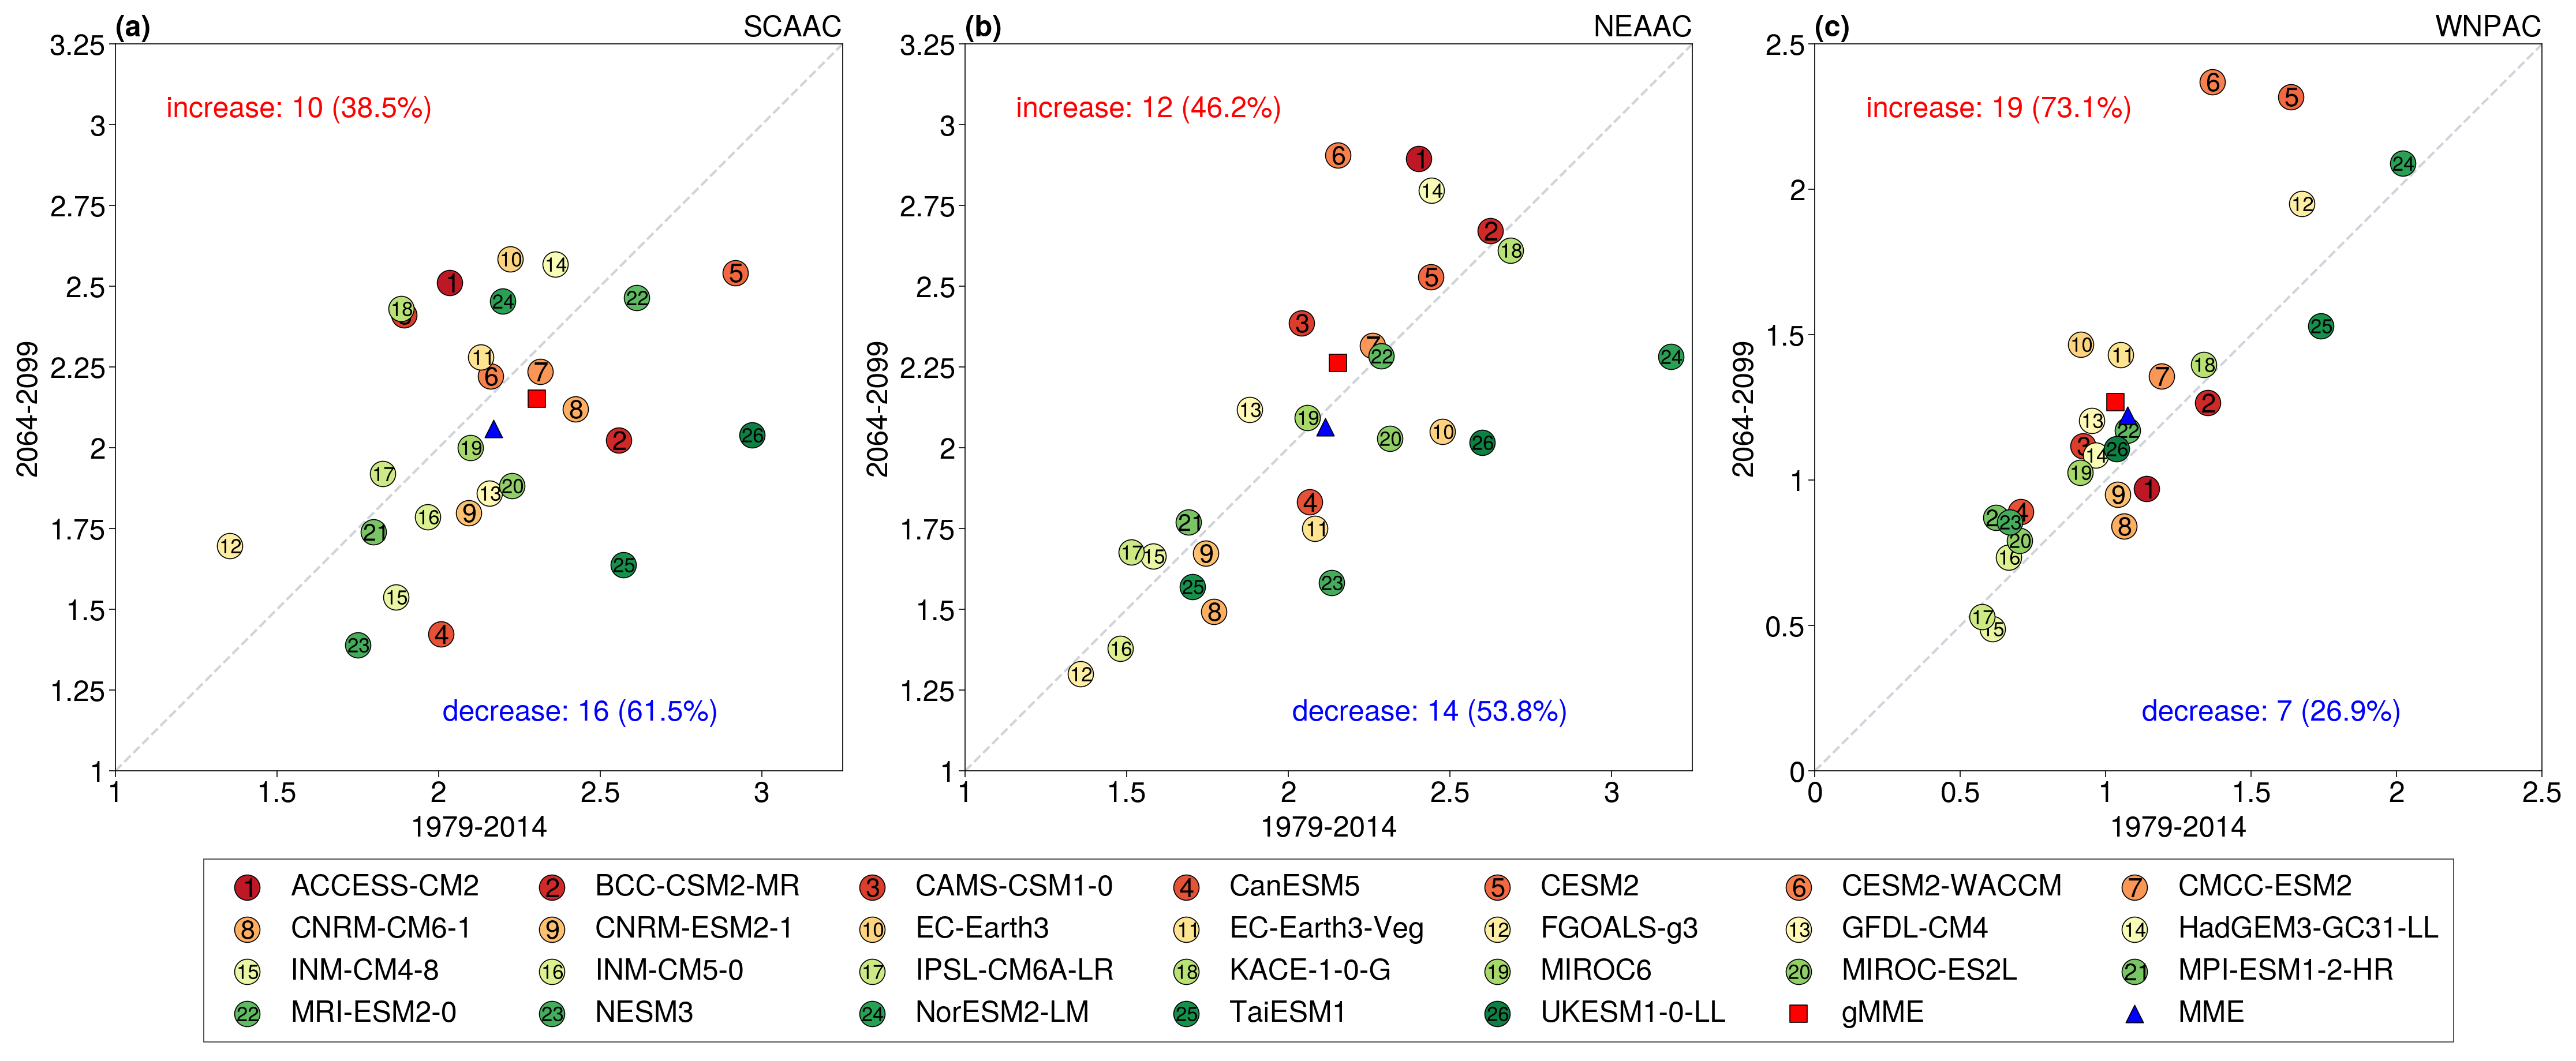

In [66]:
pplt.rc.reset()
pplt.rc["legend.fontsize"]=18
fig_vorstd = pplt.figure(span=False, share=False, refheight="16cm", refwidth="16cm", wspace=8.5, hspace=5.5, outerpad=1.0)
axs = fig_vorstd.subplots(ncols=3, nrows=1)
# cycle = pplt.Cycle('blues', 'acton', 'oranges', 'greens', 26, right=0.05)
cycle = pplt.Cycle("RdYlGn", 26, left=0.05, right=0.95)
hs = []
for num_models, mod in enumerate(models.data):
    h = axs[0].scatter(vorstd_his_WAhigh_JJA.sel(models=mod)*1e6, vorstd_ssp585_p3_WAhigh_JJA.sel(models=mod)*1e6, cycle=cycle, labels=mod, marker="o", markersize=250, ec="black", zorder=num_models)
    htext = axs[0].scatter(vorstd_his_WAhigh_JJA.sel(models=mod)*1e6, vorstd_ssp585_p3_WAhigh_JJA.sel(models=mod)*1e6, marker="${}$".format(num_models+1), markersize=140 if num_models<=8 or num_models==10 else 180, color="black", zorder=num_models, linewidth=0)
    hs.append((h,htext))
    
    axs[1].scatter(vorstd_his_EAhigh_JJA.sel(models=mod)*1e6, vorstd_ssp585_p3_EAhigh_JJA.sel(models=mod)*1e6, cycle=cycle, marker="o", markersize=250, ec="black", zorder=num_models)
    axs[1].scatter(vorstd_his_EAhigh_JJA.sel(models=mod)*1e6, vorstd_ssp585_p3_EAhigh_JJA.sel(models=mod)*1e6, marker="${}$".format(num_models+1), markersize=140 if num_models<=8 or num_models==10 else 180, color="black", zorder=num_models, linewidth=0)
    
    axs[2].scatter(vorstd_his_WNPhigh_JJA.sel(models=mod)*1e6, vorstd_ssp585_p3_WNPhigh_JJA.sel(models=mod)*1e6, cycle=cycle, marker="o", markersize=250, ec="black", zorder=num_models)
    axs[2].scatter(vorstd_his_WNPhigh_JJA.sel(models=mod)*1e6, vorstd_ssp585_p3_WNPhigh_JJA.sel(models=mod)*1e6, marker="${}$".format(num_models+1), markersize=140 if num_models<=8 or num_models==10 else 180, color="black", zorder=num_models, linewidth=0)

h = axs[0].scatter(vorstd_his_WAhigh_JJA_gens*1e6, vorstd_ssp585_p3_WAhigh_JJA_gens*1e6, color="red", labels="gMME", marker="s", markersize=120, ec="black", zorder=num_models)
hs.append(h)
h = axs[0].scatter(vorstd_his_WAhigh_JJA_ens*1e6, vorstd_ssp585_p3_WAhigh_JJA_ens*1e6, color="blue", labels="MME", marker="^", markersize=120, ec="black", zorder=num_models)
hs.append(h)

axs[1].scatter(vorstd_his_EAhigh_JJA_gens*1e6, vorstd_ssp585_p3_EAhigh_JJA_gens*1e6, color="red", marker="s", markersize=120, ec="black", zorder=num_models)
axs[1].scatter(vorstd_his_EAhigh_JJA_ens*1e6, vorstd_ssp585_p3_EAhigh_JJA_ens*1e6, color="blue", marker="^", markersize=120, ec="black", zorder=num_models)

axs[2].scatter(vorstd_his_WNPhigh_JJA_gens*1e6, vorstd_ssp585_p3_WNPhigh_JJA_gens*1e6, color="red", marker="s", markersize=120, ec="black", zorder=num_models)
axs[2].scatter(vorstd_his_WNPhigh_JJA_ens*1e6, vorstd_ssp585_p3_WNPhigh_JJA_ens*1e6, color="blue", marker="^", markersize=120, ec="black", zorder=num_models)

axs[0].line(np.linspace(1.0,3.25), np.linspace(1.0,3.25), zorder=0.8, color="grey4", linestyle="--")
axs[0].format(xlim=(1.0,3.25), ylim=(1.0,3.25), rtitle="SCAAC")
axs[0].text(0.45, 0.07, s="decrease: {} ({:.1f}%)".format(16, 16/26*100), fontsize=18, color="blue", transform=axs[0].transAxes)
axs[0].text(0.07, 0.90, s="increase: {} ({:.1f}%)".format(10, 10/26*100), fontsize=18, color="red", transform=axs[0].transAxes)

axs[1].line(np.linspace(1.0,3.25), np.linspace(1.0,3.25), zorder=0.8, color="grey4", linestyle="--")
axs[1].format(xlim=(1.0,3.25), ylim=(1.0,3.25), rtitle="NEAAC")
axs[1].text(0.45, 0.07, s="decrease: {} ({:.1f}%)".format(14, 14/26*100), fontsize=18, color="blue", transform=axs[1].transAxes)
axs[1].text(0.07, 0.90, s="increase: {} ({:.1f}%)".format(12, 12/26*100), fontsize=18, color="red", transform=axs[1].transAxes)

axs[2].line(np.linspace(0.0,2.5), np.linspace(0.0,2.5), zorder=0.8, color="grey4", linestyle="--")
axs[2].format(xlim=(0.0,2.5), ylim=(0.0,2.5), rtitle="WNPAC")
axs[2].text(0.45, 0.07, s="decrease: {} ({:.1f}%)".format(7, 7/26*100), fontsize=18, color="blue", transform=axs[2].transAxes)
axs[2].text(0.07, 0.90, s="increase: {} ({:.1f}%)".format(19, 19/26*100), fontsize=18, color="red", transform=axs[2].transAxes)

axs.format(tickminor=False, xlabel="1979-2014", ylabel="2064-2099", ticklabelsize=18, labelsize=18)
fig_vorstd.legend(hs, ncols=7, loc="b")
fig_vorstd.format(abc="(a)", abcloc="l", rc_kw={"figure.facecolor":"white", "font.large":18, "grid":False})
pplt.rc.reset()

## 回复意见补充图2：AIRI站点分布

In [ ]:
# plot the box
pplt.rc["grid"] = False

cl = 180  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

figR2_AIRI_stnloc = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=3.5, outerpad=2.0)
axs = figR2_AIRI_stnloc.subplots(ncols=1, nrows=1, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([70, 80, 90, 100])  # 设置经度刻度
yticks = np.arange(10, 31, 10)  # 设置纬度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [65.0, 100.0, 5, 35]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=10)
# ===================================================
# for ax in axs:
#     # India area
#     x0 = India_W
#     y0 = India_S
#     width = India_E-India_W
#     height = India_N-India_S
#     sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)
axs.scatter(stn_lon, stn_lat, marker="o", color="bisque", edgecolor="orange", zorder=1.1)
axs.format(ltitle="Stn_loc", rtitle="306")
figR2_AIRI_stnloc.format(rc_kw={"grid": False, "reso": "lo", "figure.facecolor":"white", "font.large": 13})

## 回复意见补充图3：降水回归到GPCP印度半岛降水

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/hom

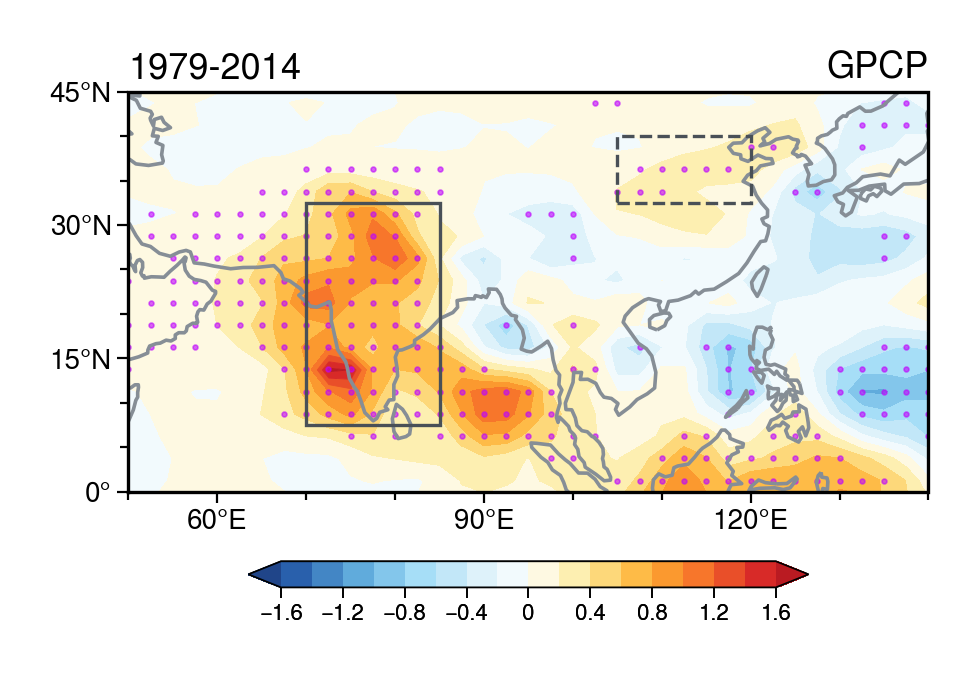

In [46]:
pplt.rc.reset()
pplt.rc.grid = False
# pplt.rc.reset()
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

figR2_SASMR_GPCP_pre_regress = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=4.5, outerpad=2.0)
# plot_array = np.reshape(range(1, 1), (1, 1))
ncols=1
nrows=1
axs = figR2_SASMR_GPCP_pre_regress.subplots(ncols=ncols, nrows=nrows, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [50.0, 140.0, yticks[0], 45.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=10)

# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
for ax in axs:
    # India area
    x0 = India_W
    y0 = India_S
    width = India_E-India_W
    height = India_N-India_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)
for ax in axs:
    # NC area
    x0 = NC_W
    y0 = NC_S
    width = NC_E-NC_W
    height = NC_N-NC_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linewidth=1.2)
# ===================================================
con = axs[0].contourf(
    pre_GPCP_India_pre_slope,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    pre_GPCP_India_pre_slope, axs[0], n, np.where(pre_GPCP_India_pre_pvalue[::n, ::n] < 0.10), "bright purple", 12.0,
)

axs[0].format(
    ltitle="1979-2014", rtitle="GPCP",
)
cb = figR2_SASMR_GPCP_pre_regress.colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8)
cb.set_ticks(np.arange(-2.0,2.1, 0.4))
axs.format(linewidth=1.2)
figR2_SASMR_GPCP_pre_regress.format(rc_kw={"grid": False, "reso": "lo", "figure.facecolor":"white", "font.large": 13})
pplt.rc.reset()